In [1]:
%load_ext autoreload
%autoreload 2
    
import pandas as pd
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 500)

import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()

import pymc3 as pm
print(pm.__version__)
import theano.tensor as tt
import patsy

3.4.1


In [2]:
SEED = 123
DRAWS = 5000
BURNIN = 1000
TUNE = 1000
CHAINS = 4
CORES = 2

# Reaction Times In A Sleep Deprivation Study
The dataset contains the average reaction time per day for subjects in a sleep deprivation study. On day 0 the subjects had their normal amount of sleep. Starting that night they were restricted to 3 hours of sleep per night. The observations represent the average reaction time on a series of tests given each day to each subject. Data from: https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/lme4/sleepstudy.csv

### Data loading

In [3]:
sleep = pd.read_csv('../datasets/sleepstudy.csv', index_col=0)
sleep['Subject'] = pd.Categorical(sleep['Subject'], ordered=False)
sleep.head(15)

Reaction  Days Subject
1   249.5600     0     308
2   258.7047     1     308
3   250.8006     2     308
4   321.4398     3     308
5   356.8519     4     308
6   414.6901     5     308
7   382.2038     6     308
8   290.1486     7     308
9   430.5853     8     308
10  466.3535     9     308
11  222.7339     0     309
12  205.2658     1     309
13  202.9778     2     309
14  204.7070     3     309
15  207.7161     4     309

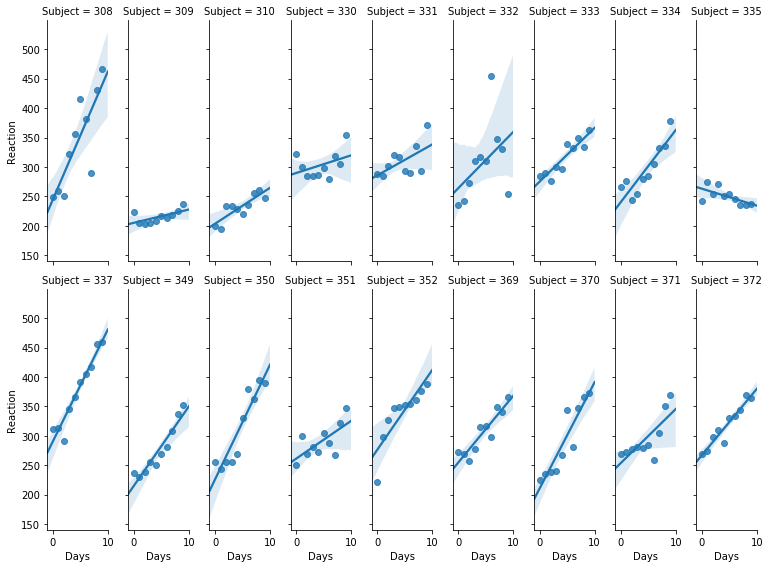

In [4]:
sns.lmplot(x="Days", y="Reaction", col="Subject", data=sleep, col_wrap=9, palette="muted", aspect=0.3, size=4)


## Model 1: Random effect on only the intercepts

Design matrix for the fixed effect

In [5]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)
X[1:10, :]

array([[1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.],
       [1., 5.],
       [1., 6.],
       [1., 7.],
       [1., 8.],
       [1., 9.]])

Design matrix for the random effect (intercept only). This means that each subject will deviate from the average intercecpt by some amount, but the slope will be the same across participants

In [6]:
Z = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z = np.asarray(Z)
Z

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [7]:
Y = np.asarray(sleep['Reaction'])
Y.mean()

298.50789166666664

In [8]:
with pm.Model() as model_intercept:

    #beta_X = pm.Normal('beta_X', mu=0, sd=100, shape=X.shape[1])
    
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # Intercept is constrained to be positive because reaction time are positive only
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope)
    
    estimate_X = pm.math.dot(X, beta_X)

    # Non Centered version
    # The idea behind the non-centered version is to make sampling easier by sampling on probability distributions with the similar dimension. 
    # For example if the sampler is tune on a Normal (0, 1), it will have worse performance in sampling tiny values because the leap frog jump will be to long.
    # Hence, we sample the gamma_raw value and a scaler independently. Normal(0, 30) is the same as N(0, 1) * 30
    sigma_Z = pm.HalfNormal('sigma_Z', sd=100) # The scaler is quite wide since the intercept value can vary quite much around the average value of 300 ms.

    gamma_Z_raw = pm.Normal('gamma_Z_raw', mu=0, sd=1, shape=Z.shape[1])
    gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_raw * sigma_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=100) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma_unexplained, observed=Y)
    
    trace_intercept = pm.sample(draws=DRAWS+BURNIN, chains=CHAINS, cores=CORES, tune=TUNE, random_seed=SEED, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_unexplained, gamma_Z_raw, sigma_Z, beta_X_slope, beta_X_intercept]
Sampling 4 chains: 100%|█████████████| 28000/28000 [02:48<00:00, 166.04draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [9]:
trace_intercept = trace_intercept[BURNIN: ]

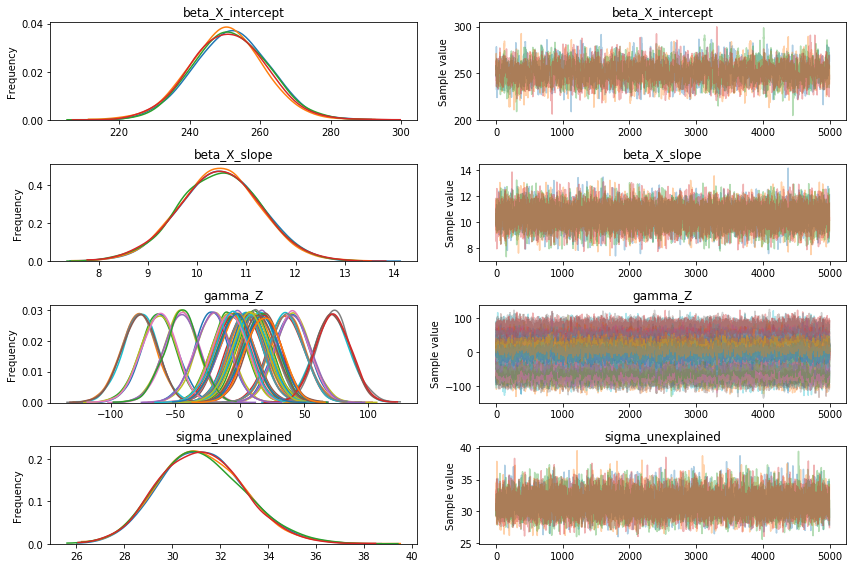

In [10]:
_ = pm.traceplot(trace_intercept, varnames=['beta_X_intercept', 'beta_X_slope', 'gamma_Z', 'sigma_unexplained'])

In [11]:
pm.summary(trace_intercept)

mean         sd  mc_error     hpd_2.5    hpd_97.5  \
beta_X_slope        10.462142   0.818257  0.006373    8.889248   12.120738   
gamma_Z_raw__0       1.057878   0.381258  0.006298    0.315067    1.797640   
gamma_Z_raw__1      -2.012746   0.474537  0.008149   -2.946607   -1.104738   
gamma_Z_raw__2      -1.629668   0.433351  0.007195   -2.496283   -0.825165   
gamma_Z_raw__3       0.116969   0.340181  0.005403   -0.557060    0.782676   
gamma_Z_raw__4       0.268785   0.341950  0.005329   -0.409125    0.928912   
gamma_Z_raw__5       0.215185   0.347019  0.005210   -0.480842    0.890107   
gamma_Z_raw__6       0.429767   0.346587  0.005581   -0.249803    1.102285   
gamma_Z_raw__7      -0.071596   0.344601  0.005236   -0.747953    0.599885   
gamma_Z_raw__8      -1.166913   0.387408  0.006508   -1.934507   -0.430418   
gamma_Z_raw__9       1.869014   0.456847  0.007665    1.022791    2.801455   
gamma_Z_raw__10     -0.544386   0.353780  0.005604   -1.253995    0.132836   
gamma_Z_raw__11      0.368088   0.345897  0.005125   -0.280477    1.072582   
gamma_Z_raw__12     -0.201513   0.341515  0.005310   -0.870255    0.461326   
gamma_Z_raw__13      0.943854   0.374643  0.005846    0.212320    1.678997   
gamma_Z_raw__14      0.184725   0.343008  0.005399   -0.481053    0.868128   
gamma_Z_raw__15     -0.163207   0.343002  0.005487   -0.844572    0.496598   
gamma_Z_raw__16     -0.082349   0.342480  0.005265   -0.764057    0.575826   
gamma_Z_raw__17      0.471375   0.352038  0.005642   -0.190946    1.187932   
beta_X_intercept   251.299349  10.523901  0.220770  230.253535  271.422340   
sigma_Z             39.998819   8.002776  0.147620   26.269660   56.339493   
gamma_Z__0          40.971079  13.346663  0.216636   15.006719   66.967534   
gamma_Z__1         -77.919623  13.399640  0.208807 -103.830735  -51.623428   
gamma_Z__2         -63.099602  13.420901  0.203279  -89.565895  -37.047348   
gamma_Z__3           4.520001  13.325076  0.218988  -22.276374   30.111485   
gamma_Z__4          10.399979  13.295669  0.213407  -15.607648   36.453368   
gamma_Z__5           8.312255  13.512030  0.211981  -18.164973   34.834597   
gamma_Z__6          16.646383  13.305661  0.218241  -10.026026   41.832304   
gamma_Z__7          -2.782555  13.484148  0.214322  -29.681880   22.841855   
gamma_Z__8         -45.192317  13.294842  0.212725  -72.458376  -20.175082   
gamma_Z__9          72.383418  13.467719  0.217043   46.187887   98.859874   
gamma_Z__10        -21.072487  13.388112  0.216036  -48.145586    4.760824   
gamma_Z__11         14.260025  13.355449  0.201488  -11.623508   40.236738   
gamma_Z__12         -7.804712  13.310557  0.214432  -34.614903   16.930605   
gamma_Z__13         36.551113  13.440179  0.210892   11.175715   63.809144   
gamma_Z__14          7.140582  13.367469  0.217406  -18.931047   33.370482   
gamma_Z__15         -6.329160  13.422052  0.220471  -32.809741   19.985589   
gamma_Z__16         -3.212523  13.436731  0.214113  -30.549191   22.075096   
gamma_Z__17         18.245816  13.450792  0.220939   -7.247926   44.955868   
sigma_unexplained   31.256440   1.759007  0.016440   27.926420   34.776862   

                          n_eff      Rhat  
beta_X_slope       14712.458736  1.000034  
gamma_Z_raw__0      4513.025443  1.000894  
gamma_Z_raw__1      4154.778540  1.001631  
gamma_Z_raw__2      4259.894386  1.001965  
gamma_Z_raw__3      4788.688564  1.001598  
gamma_Z_raw__4      4810.255072  1.001414  
gamma_Z_raw__5      4898.234172  1.001434  
gamma_Z_raw__6      4686.267023  1.001119  
gamma_Z_raw__7      4797.453619  1.001501  
gamma_Z_raw__8      4348.710184  1.001799  
gamma_Z_raw__9      4240.693933  1.000633  
gamma_Z_raw__10     4860.157552  1.001565  
gamma_Z_raw__11     4992.838309  1.001227  
gamma_Z_raw__12     4989.016487  1.002069  
gamma_Z_raw__13     4789.915231  1.000523  
gamma_Z_raw__14     4718.438014  1.001126  
gamma_Z_raw__15     4922.509148  1.001223  
gamma_Z_raw__16     4954.548335  1

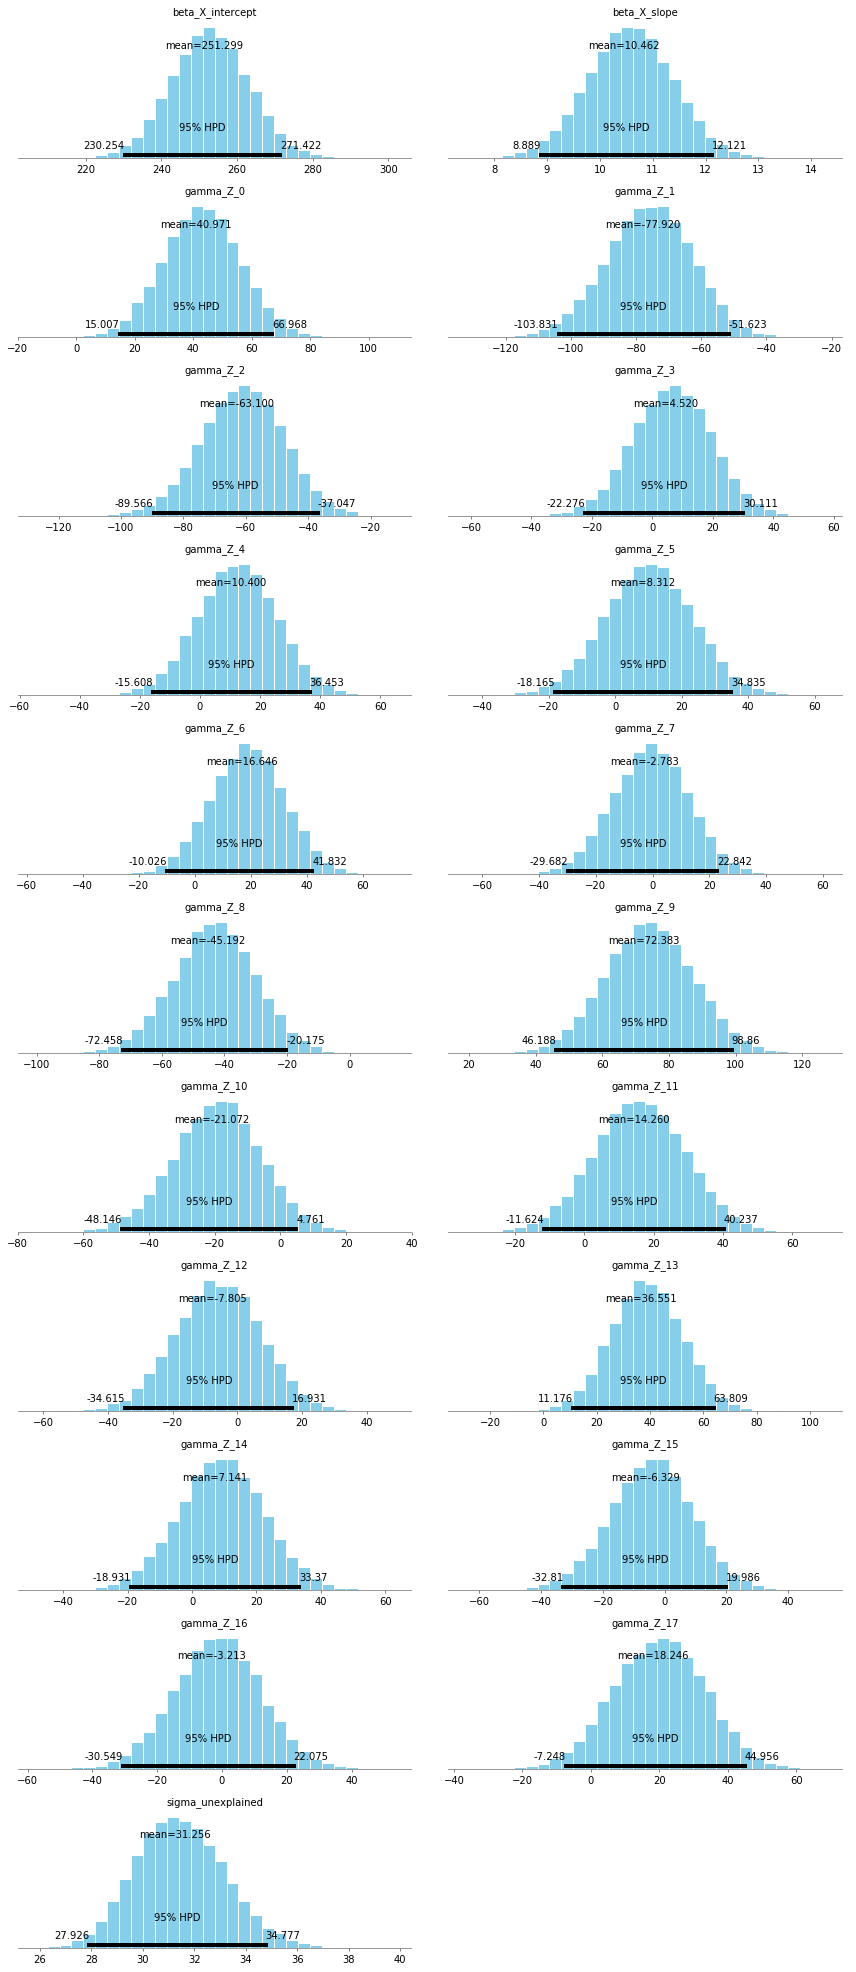

In [12]:
pm.plot_posterior(trace_intercept, varnames=['beta_X_intercept', 'beta_X_slope', 'gamma_Z', 'sigma_unexplained']);

## Posterior predictive check

In [13]:
trace_df = pm.trace_to_dataframe(trace_intercept)

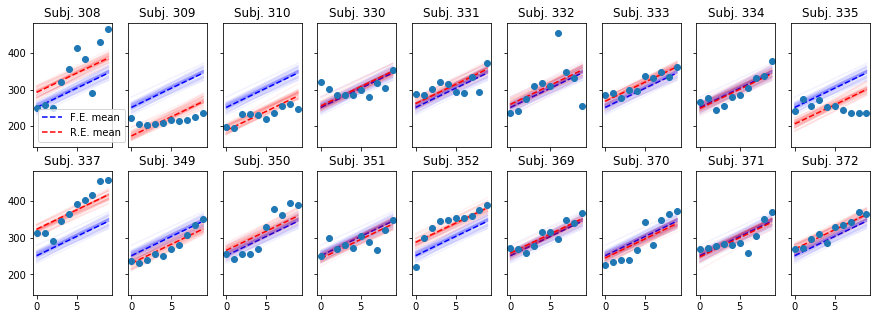

In [14]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500]):
        ax[i].plot(days, b0 + days*b1, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1, g0 in zip(trace_df['beta_X_intercept'][::500], 
                  trace_df['beta_X_slope'][::500],
                  trace_df['gamma_Z__{}'.format(i)][::500]):
        ax[i].plot(days, (b0 + g0) + days * b1, '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z__{}'.format(i)].mean() + 
               days * trace_df['beta_X_slope'].mean(), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend();

100%|███████████████████████████████████████| 250/250 [00:00<00:00, 395.16it/s]


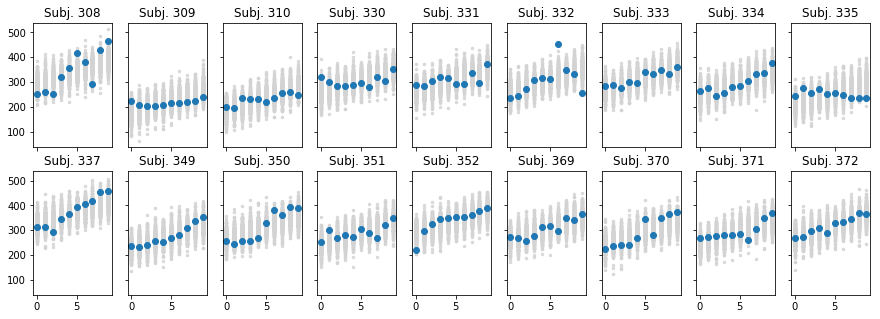

In [15]:
ppc = pm.sample_ppc(trace_intercept, samples=250, model=model_intercept)

days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightgray')
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))

In [16]:
waic = pm.waic(trace_intercept, model_intercept, progressbar=True)
waic.WAIC

20000it [00:02, 9108.55it/s]
d:\dev\pymc3\pymc3\stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


1769.416931597846

In [17]:
loo = pm.loo(trace_intercept, model_intercept)
loo.LOO

1769.9803020521476

## Include second order coefficients

In [18]:
X = patsy.dmatrix("1 + Days + np.power(Days, 2)", data=sleep, return_type='dataframe')
X = np.asarray(X)
X

array([[ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.

In [19]:
Z = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z = np.asarray(Z)
Z

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [20]:
with pm.Model() as model_intercept_pow2:

    #beta_X = pm.Normal('beta_X', mu=0, sd=100, shape=X.shape[1])
    
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # Intercept is constrained to be positive because reaction time are positive only
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X_slope_pow2 = pm.Normal('beta_X_slope_pow2', mu=0, sd=100)

    beta_X = tt.stack(beta_X_intercept, beta_X_slope, beta_X_slope_pow2)
    
    estimate_X = pm.math.dot(X, beta_X)

    # Non Centered version
    # The idea behind the non-centered version is to make sampling easier by sampling on probability distributions with the similar dimension. 
    # For example if the sampler is tune on a Normal (0, 1), it will have worse performance in sampling tiny values because the leap frog jump will be to long.
    # Hence, we sample the gamma_raw value and a scaler independently. Normal(0, 30) is the same as N(0, 1) * 30
    sigma_Z = pm.HalfNormal('sigma_Z', sd=100) # The scaler is quite wide since the intercept value can vary quite much around the average value of 300 ms.

    gamma_Z_raw = pm.Normal('gamma_Z_raw', mu=0, sd=1, shape=Z.shape[1])
    gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_raw * sigma_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=100) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma_unexplained, observed=Y)
    
    trace_intercept_pow2 = pm.sample(draws=DRAWS+BURNIN, chains=CHAINS, cores=CORES, tune=TUNE, random_seed=SEED, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_unexplained, gamma_Z_raw, sigma_Z, beta_X_slope_pow2, beta_X_slope, beta_X_intercept]
Sampling 4 chains: 100%|█████████████| 28000/28000 [03:15<00:00, 143.57draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [21]:
trace_intercept_pow2 = trace_intercept_pow2[BURNIN: ]

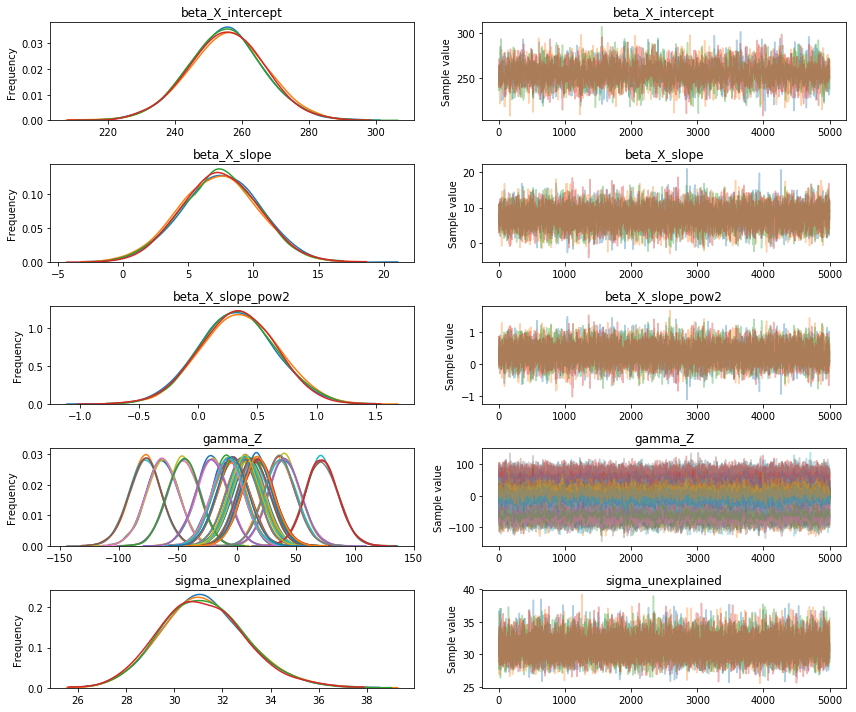

In [22]:
_ = pm.traceplot(trace_intercept_pow2, varnames=['beta_X_intercept', 'beta_X_slope', 'beta_X_slope_pow2', 'gamma_Z', 'sigma_unexplained'])

In [23]:
pm.summary(trace_intercept_pow2)

mean         sd  mc_error     hpd_2.5    hpd_97.5  \
beta_X_slope         7.443108   2.971367  0.038192    1.761680   13.341599   
beta_X_slope_pow2    0.336618   0.318486  0.004001   -0.294791    0.952311   
gamma_Z_raw__0       1.055971   0.383183  0.006096    0.328558    1.837379   
gamma_Z_raw__1      -2.015677   0.473451  0.007508   -2.930567   -1.101132   
gamma_Z_raw__2      -1.637049   0.435949  0.006792   -2.514023   -0.813941   
gamma_Z_raw__3       0.116835   0.345621  0.005314   -0.568119    0.774909   
gamma_Z_raw__4       0.265066   0.347371  0.005305   -0.406559    0.956205   
gamma_Z_raw__5       0.218260   0.343580  0.005079   -0.454603    0.893226   
gamma_Z_raw__6       0.425898   0.349349  0.005233   -0.245739    1.112431   
gamma_Z_raw__7      -0.074638   0.342639  0.004917   -0.747346    0.597905   
gamma_Z_raw__8      -1.173123   0.395042  0.006190   -1.950784   -0.406804   
gamma_Z_raw__9       1.873032   0.456744  0.006887    0.993360    2.779039   
gamma_Z_raw__10     -0.547801   0.352568  0.005311   -1.232298    0.146659   
gamma_Z_raw__11      0.366894   0.350357  0.005065   -0.332588    1.041371   
gamma_Z_raw__12     -0.203288   0.344582  0.005157   -0.893878    0.461449   
gamma_Z_raw__13      0.945428   0.376911  0.005722    0.189940    1.659667   
gamma_Z_raw__14      0.181964   0.343760  0.004995   -0.492554    0.850083   
gamma_Z_raw__15     -0.164565   0.345628  0.005226   -0.815781    0.529613   
gamma_Z_raw__16     -0.084589   0.345776  0.005054   -0.764264    0.591329   
gamma_Z_raw__17      0.472002   0.356560  0.005151   -0.207691    1.190045   
beta_X_intercept   255.384559  11.374554  0.220807  232.353679  277.448486   
sigma_Z             39.807930   7.832822  0.127268   26.124583   55.346099   
gamma_Z__0          40.735632  13.527818  0.202442   14.559265   67.812179   
gamma_Z__1         -77.761078  13.685354  0.206504 -104.864416  -50.850641   
gamma_Z__2         -63.148941  13.691421  0.210191  -90.514900  -36.446796   
gamma_Z__3           4.509021  13.612311  0.212312  -21.315445   32.048805   
gamma_Z__4          10.218213  13.525618  0.208392  -16.689490   36.481848   
gamma_Z__5           8.411997  13.490589  0.203942  -17.974360   35.190096   
gamma_Z__6          16.446391  13.486183  0.204599   -9.220875   43.772965   
gamma_Z__7          -2.892254  13.519709  0.194898  -29.803102   22.687398   
gamma_Z__8         -45.231201  13.549968  0.205003  -71.809152  -18.759711   
gamma_Z__9          72.271921  13.686528  0.196471   45.291488   99.061529   
gamma_Z__10        -21.151807  13.484524  0.207145  -48.293308    4.499014   
gamma_Z__11         14.169598  13.567144  0.197155  -12.800087   40.166464   
gamma_Z__12         -7.847767  13.473556  0.204251  -33.604304   19.404232   
gamma_Z__13         36.484167  13.635734  0.200310    9.990799   63.275253   
gamma_Z__14          7.032245  13.496464  0.199553  -19.593072   33.231492   
gamma_Z__15         -6.344968  13.552575  0.210168  -33.412296   19.538240   
gamma_Z__16         -3.274905  13.594358  0.205372  -30.375519   23.339648   
gamma_Z__17         18.194119  13.685259  0.199241   -9.717707   44.404515   
sigma_unexplained   31.236396   1.763999  0.014112   27.673090   34.635666   

                          n_eff      Rhat  
beta_X_slope        7145.580300  1.000707  
beta_X_slope_pow2   7282.115880  1.000756  
gamma_Z_raw__0      3817.846538  1.000151  
gamma_Z_raw__1      3961.905910  0.999908  
gamma_Z_raw__2      4105.448216  0.999941  
gamma_Z_raw__3      4320.995092  1.000064  
gamma_Z_raw__4      4455.988532  1.000149  
gamma_Z_raw__5      4318.572323  1.000193  
gamma_Z_raw__6      4372.319931  1.000351  
gamma_Z_raw__7      4373.686847  1.000135  
gamma_Z_raw__8      4157.503600  0.999927  
gamma_Z_raw__9      3952.139786  1.000229  
gamma_Z_raw__10     4325.784663  0.999967  
gamma_Z_raw__11     4503.615469  1.000071  
gamma_Z_raw__12     4516.719448  1.000049  
gamma_Z_raw__13     4171.435011  1.000305  


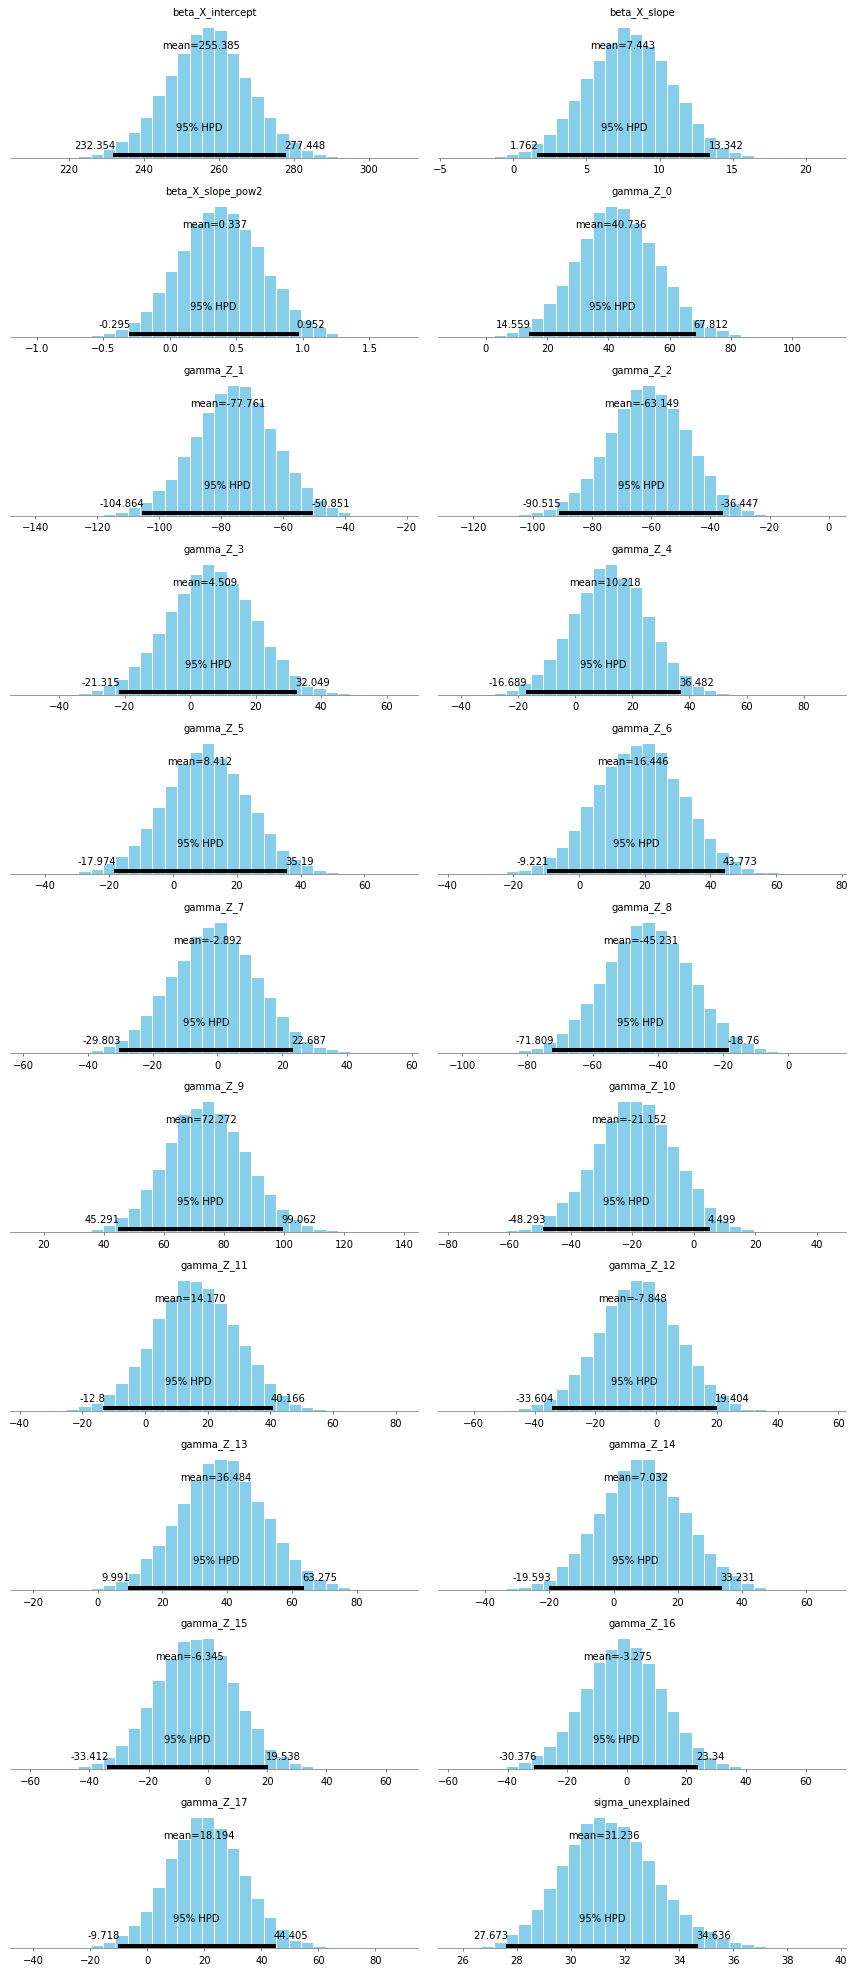

In [24]:
pm.plot_posterior(trace_intercept_pow2, varnames=['beta_X_intercept', 'beta_X_slope',  'beta_X_slope_pow2',  'gamma_Z', 'sigma_unexplained']);

## Posterior predictive check

In [25]:
trace_df = pm.trace_to_dataframe(trace_intercept_pow2)

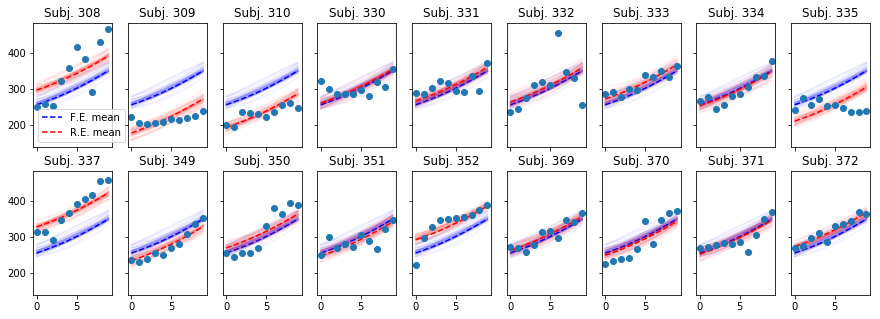

In [26]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1, b2 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500], 
                      trace_df['beta_X_slope_pow2'][::500]):
        ax[i].plot(days, b0 + days*b1 + (days**2)*b2, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, 
               trace_df['beta_X_intercept'].mean() + \
               days*trace_df['beta_X_slope'].mean() + \
               (days**2)*trace_df['beta_X_slope_pow2'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1 ,b2, g0 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500], 
                      trace_df['beta_X_slope_pow2'][::500],
                      trace_df['gamma_Z__{}'.format(i)][::500]):
        ax[i].plot(days, 
                   b0 + g0 + \
                   days * b1 + \
                   (days**2) * b2, '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z__{}'.format(i)].mean() + 
               days * trace_df['beta_X_slope'].mean() + \
               (days**2) * trace_df['beta_X_slope_pow2'].mean(), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend();

100%|███████████████████████████████████████| 250/250 [00:00<00:00, 503.31it/s]


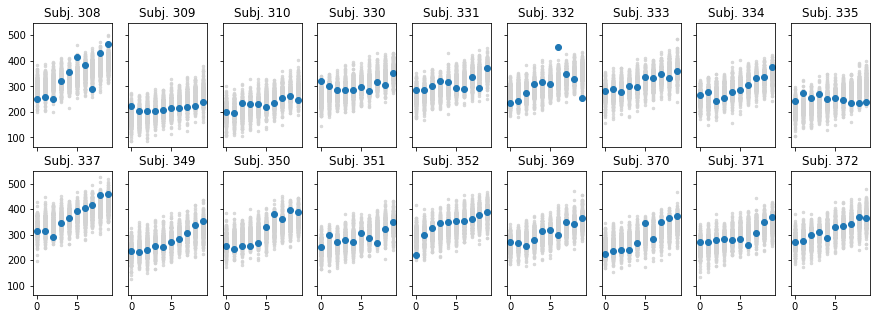

In [27]:
ppc = pm.sample_ppc(trace_intercept_pow2, samples=250, model=model_intercept_pow2)

days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightgray')
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))

In [28]:
waic = pm.waic(trace_intercept_pow2, model_intercept_pow2, progressbar=True)
waic.WAIC

20000it [00:02, 7234.81it/s]
d:\dev\pymc3\pymc3\stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


1770.8149429513905

In [29]:
loo = pm.loo(trace_intercept_pow2, model_intercept_pow2)
loo.LOO

1771.3901762423034

## Random effect on the slopes only

In [30]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)
X[1:10, :]

array([[1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.],
       [1., 5.],
       [1., 6.],
       [1., 7.],
       [1., 8.],
       [1., 9.]])

In [31]:
Z = patsy.dmatrix('0 + Subject:Days', data=sleep, return_type='dataframe')
Z = np.asarray(Z)
Z

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 8.],
       [0., 0., 0., ..., 0., 0., 9.]])

In [32]:
Y = np.asarray(sleep['Reaction'])

In [33]:
with pm.Model() as model_slope:
   
    ## Fixed effect
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # contrain it to positive values
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope)
    
    estimate_X = pm.math.dot(X, beta_X)
    
    ## Random effect
    # Non Centered version
    sigma_Z = pm.HalfNormal('sigma_Z', sd=100)
    gamma_Z_raw = pm.Normal('gamma_Z_raw', mu=0, sd=1, shape=Z.shape[1])
    gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_raw * sigma_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z) 
    
    ## likelihood
    mu_estimate = pm.Deterministic('mu_estimate', estimate_X + estimate_Z)
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=1000) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=mu_estimate, sd=sigma_unexplained, observed=Y)
    
    trace_slope = pm.sample(draws=DRAWS+BURNIN, chains=CHAINS, cores=CORES, tune=TUNE, random_seed=SEED, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_unexplained, gamma_Z_raw, sigma_Z, beta_X_slope, beta_X_intercept]
Sampling 4 chains: 100%|█████████████| 28000/28000 [02:15<00:00, 206.41draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [34]:
trace_slope = trace_slope[BURNIN: ]

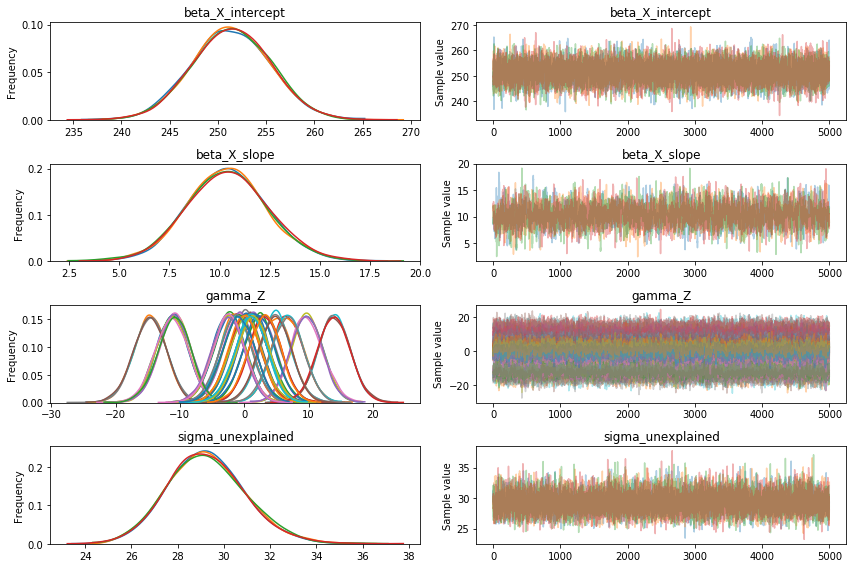

In [35]:
_ = pm.traceplot(trace_slope, varnames=['beta_X_intercept', 'beta_X_slope', 'gamma_Z', 'sigma_unexplained'])

In [36]:
pm.summary(trace_slope)

mean         sd  mc_error     hpd_2.5    hpd_97.5  \
beta_X_slope        10.390200   1.992783  0.038437    6.619473   14.472548   
gamma_Z_raw__0       1.278124   0.384698  0.006030    0.555625    2.054977   
gamma_Z_raw__1      -1.926824   0.458445  0.007702   -2.861666   -1.085712   
gamma_Z_raw__2      -1.479196   0.407938  0.006510   -2.299013   -0.709783   
gamma_Z_raw__3      -0.167207   0.319298  0.004702   -0.810520    0.446299   
gamma_Z_raw__4       0.036080   0.323054  0.004588   -0.615281    0.663547   
gamma_Z_raw__5       0.150920   0.320221  0.004875   -0.509669    0.757666   
gamma_Z_raw__6       0.307499   0.325591  0.004607   -0.336151    0.944053   
gamma_Z_raw__7       0.010837   0.318691  0.004693   -0.615699    0.631840   
gamma_Z_raw__8      -1.422340   0.399750  0.006164   -2.193116   -0.645730   
gamma_Z_raw__9       1.837735   0.446213  0.007576    0.993392    2.728214   
gamma_Z_raw__10     -0.327166   0.324916  0.004571   -0.976339    0.295880   
gamma_Z_raw__11      0.634168   0.335500  0.005135   -0.005744    1.310318   
gamma_Z_raw__12     -0.302181   0.321287  0.005067   -0.946187    0.308392   
gamma_Z_raw__13      0.887466   0.352715  0.005620    0.205587    1.582166   
gamma_Z_raw__14      0.189833   0.319376  0.004870   -0.428529    0.824348   
gamma_Z_raw__15      0.152088   0.321356  0.004830   -0.502677    0.754822   
gamma_Z_raw__16     -0.107999   0.319588  0.004831   -0.744894    0.507225   
gamma_Z_raw__17      0.421042   0.326404  0.004900   -0.195479    1.082336   
beta_X_intercept   251.411415   4.006216  0.037291  243.505917  259.085286   
sigma_Z              7.863523   1.562089  0.027925    5.124896   11.027376   
gamma_Z__0           9.726001   2.481818  0.037394    4.756018   14.470653   
gamma_Z__1         -14.654118   2.501060  0.038663  -19.431480   -9.616208   
gamma_Z__2         -11.248273   2.484208  0.037467  -16.268112   -6.564341   
gamma_Z__3          -1.269535   2.458300  0.037474   -5.969865    3.703549   
gamma_Z__4           0.278759   2.488284  0.036470   -4.550175    5.379335   
gamma_Z__5           1.148509   2.460431  0.038224   -3.699644    6.025203   
gamma_Z__6           2.341332   2.484624  0.035676   -2.624347    7.099278   
gamma_Z__7           0.084720   2.464950  0.037378   -4.686172    4.974597   
gamma_Z__8         -10.817291   2.473898  0.035450  -15.854279   -6.121597   
...                       ...        ...       ...         ...         ...   
mu_estimate__151   262.959503   3.784201  0.033418  255.347789  270.179718   
mu_estimate__152   274.507591   4.364847  0.034121  265.941607  282.984101   
mu_estimate__153   286.055679   5.499536  0.039153  275.589595  296.917517   
mu_estimate__154   297.603767   6.920925  0.047149  283.930502  311.013037   
mu_estimate__155   309.151855   8.486154  0.056872  292.507562  325.706971   
mu_estimate__156   320.699944  10.128756  0.067580  300.564421  340.231803   
mu_estimate__157   332.248032  11.816510  0.078874  308.717908  354.995768   
mu_estimate__158   343.796120  13.532531  0.090534  317.867370  370.807670   
mu_estimate__159   355.344208  15.267291  0.102435  325.438761  385.133262   
mu_estimate__160   251.411415   4.006216  0.037291  243.505917  259.085286   
mu_estimate__161   260.978712   3.792203  0.032495  253.609636  268.384334   
mu_estimate__162   270.546009   4.395885  0.031393  262.074540  279.342053   
mu_estimate__163   280.113306   5.556867  0.034342  269.247142  291.228972   
mu_estimate__164   289.680603   7.003263  0.040466  276.033645  303.642249   
mu_estimate__165   299.247900   8.592123  0.048579  282.890103  316.664186   
mu_estimate__166   308.815197  10.257457  0.057849  289.297809  329.451883   
mu_estimate__167   318.382494  11.967382  0.067805  295.735586  342.592617   
mu_estimate__168   327.949791  13.705218  0.078183  301.248923  354.844875   
mu_estimate__169   337.517088  15.461556  0.088838  307.778689  368.269067   
mu_estimate__170   251.411415   4.006216  0.037

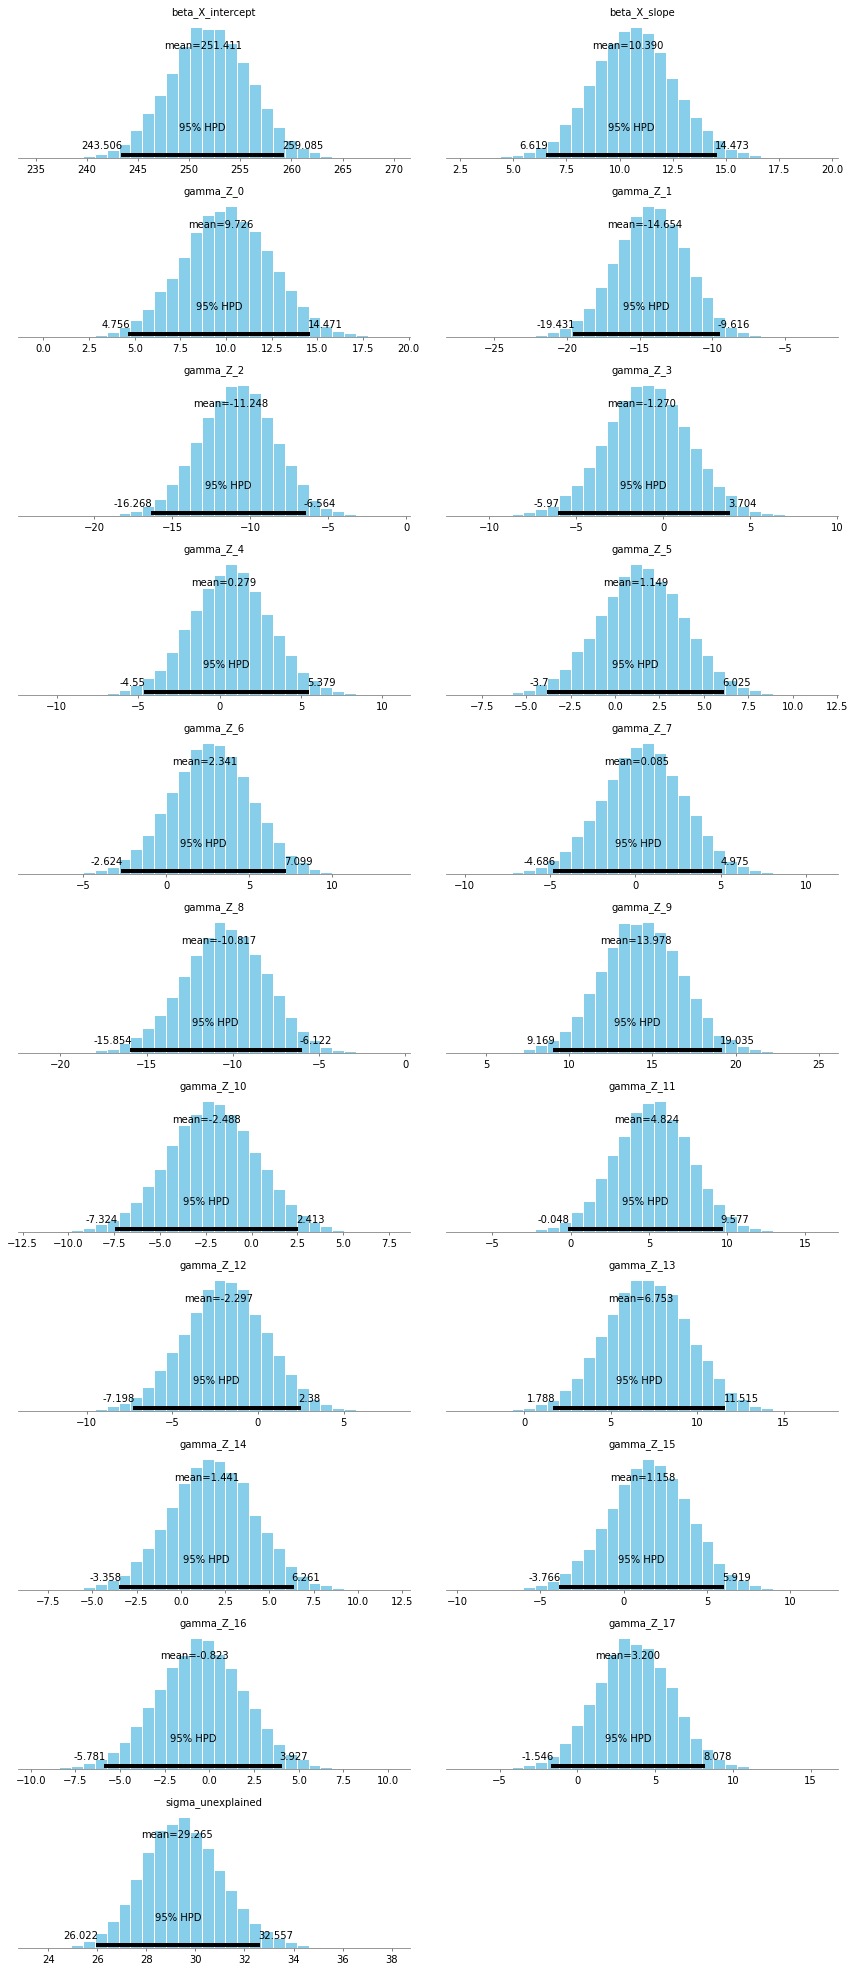

In [37]:
pm.plot_posterior(trace_slope, varnames=['beta_X_intercept', 'beta_X_slope', 'gamma_Z', 'sigma_unexplained']);

## Posterior predictive check

In [38]:
trace_df = pm.trace_to_dataframe(trace_slope)

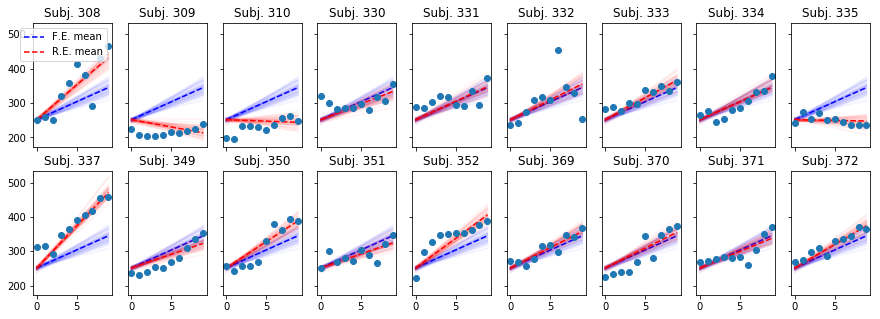

In [39]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500]):
        ax[i].plot(days, b0 + days*b1, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1, g1 in zip(trace_df['beta_X_intercept'][::500], 
                  trace_df['beta_X_slope'][::500],
                  trace_df['gamma_Z__{}'.format(i)][::500]):
        ax[i].plot(days, b0 + 
                   days * (b1 + g1), '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + 
               days * (trace_df['beta_X_slope'].mean() + trace_df['gamma_Z__{}'.format(i)].mean()), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend();

100%|███████████████████████████████████████| 250/250 [00:00<00:00, 591.36it/s]


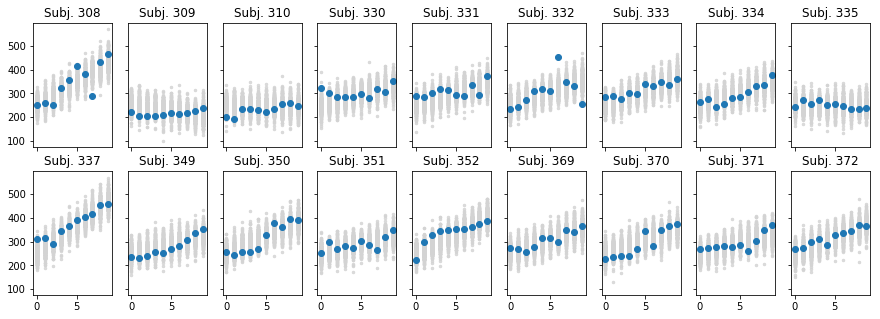

In [40]:
ppc = pm.sample_ppc(trace_slope, samples=250, model=model_slope)

days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightgray')
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))

In [41]:
waic = pm.waic(trace_slope, model_slope)
waic.WAIC

d:\dev\pymc3\pymc3\stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


1748.725097383889

In [42]:
loo = pm.loo(trace_slope, model_slope)
loo.LOO

d:\dev\pymc3\pymc3\stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


1750.710495274831

## Include second order coefficients

In [43]:
X = patsy.dmatrix("1 + Days + np.power(Days, 2)", data=sleep, return_type='dataframe')
X = np.asarray(X)
X

array([[ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.

In [44]:
Z = patsy.dmatrix('0 + Subject:Days', data=sleep, return_type='dataframe')
Z = np.asarray(Z)
Z

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 8.],
       [0., 0., 0., ..., 0., 0., 9.]])

In [45]:
with pm.Model() as model_slope_pow2:

    #beta_X = pm.Normal('beta_X', mu=0, sd=100, shape=X.shape[1])
    
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # Intercept is constrained to be positive because reaction time are positive only
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X_slope_pow2 = pm.Normal('beta_X_slope_pow2', mu=0, sd=100)

    beta_X = tt.stack(beta_X_intercept, beta_X_slope, beta_X_slope_pow2)
    
    estimate_X = pm.math.dot(X, beta_X)

    # Non Centered version
    # The idea behind the non-centered version is to make sampling easier by sampling on probability distributions with the similar dimension. 
    # For example if the sampler is tune on a Normal (0, 1), it will have worse performance in sampling tiny values because the leap frog jump will be to long.
    # Hence, we sample the gamma_raw value and a scaler independently. Normal(0, 30) is the same as N(0, 1) * 30
    sigma_Z = pm.HalfNormal('sigma_Z', sd=100) # The scaler is quite wide since the intercept value can vary quite much around the average value of 300 ms.

    gamma_Z_raw = pm.Normal('gamma_Z_raw', mu=0, sd=1, shape=Z.shape[1])
    gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_raw * sigma_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=100) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma_unexplained, observed=Y)
    
    trace_slope_pow2 = pm.sample(draws=DRAWS+BURNIN, chains=CHAINS, cores=CORES, tune=TUNE, random_seed=SEED, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_unexplained, gamma_Z_raw, sigma_Z, beta_X_slope_pow2, beta_X_slope, beta_X_intercept]
Sampling 4 chains: 100%|█████████████| 28000/28000 [03:19<00:00, 140.19draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [46]:
trace_slope_pow2 = trace_slope_pow2[BURNIN: ]

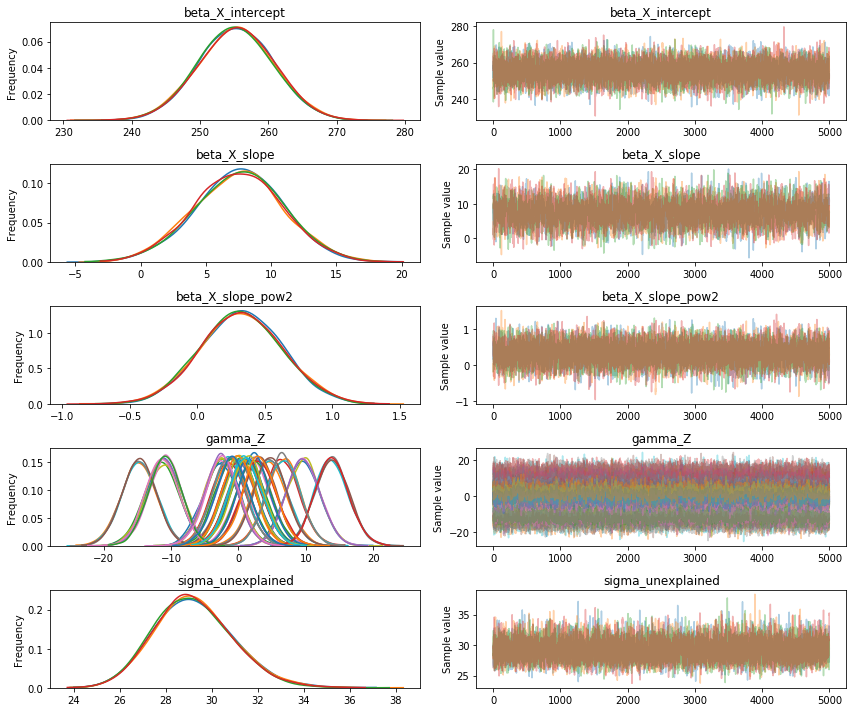

In [47]:
_ = pm.traceplot(trace_slope_pow2, varnames=['beta_X_intercept', 'beta_X_slope', 'beta_X_slope_pow2', 'gamma_Z', 'sigma_unexplained'])

In [48]:
pm.summary(trace_slope_pow2)

mean        sd  mc_error     hpd_2.5    hpd_97.5  \
beta_X_slope         7.556872  3.397009  0.055475    1.002034   14.390751   
beta_X_slope_pow2    0.327562  0.299484  0.003324   -0.279001    0.894433   
gamma_Z_raw__0       1.266371  0.388532  0.006724    0.513255    2.034948   
gamma_Z_raw__1      -1.941759  0.455862  0.006624   -2.814024   -1.034486   
gamma_Z_raw__2      -1.491452  0.406441  0.005802   -2.291998   -0.700116   
gamma_Z_raw__3      -0.180641  0.322575  0.005185   -0.816466    0.453851   
gamma_Z_raw__4       0.024146  0.322640  0.005459   -0.603561    0.664632   
gamma_Z_raw__5       0.138244  0.324731  0.005474   -0.497876    0.767350   
gamma_Z_raw__6       0.298091  0.327877  0.005520   -0.352530    0.927143   
gamma_Z_raw__7       0.000327  0.322244  0.005355   -0.623418    0.629110   
gamma_Z_raw__8      -1.438564  0.400041  0.005952   -2.183518   -0.621625   
gamma_Z_raw__9       1.830080  0.445168  0.007571    0.986881    2.715875   
gamma_Z_raw__10     -0.338979  0.328079  0.005096   -0.990256    0.293060   
gamma_Z_raw__11      0.619517  0.340738  0.005683   -0.026825    1.295653   
gamma_Z_raw__12     -0.314856  0.328533  0.005178   -0.972953    0.320647   
gamma_Z_raw__13      0.877557  0.355075  0.005954    0.177231    1.556761   
gamma_Z_raw__14      0.178288  0.325587  0.005382   -0.470746    0.807688   
gamma_Z_raw__15      0.138247  0.327553  0.005296   -0.506277    0.770618   
gamma_Z_raw__16     -0.117442  0.324198  0.005091   -0.736798    0.539499   
gamma_Z_raw__17      0.408074  0.330655  0.005599   -0.228895    1.060978   
beta_X_intercept   255.269499  5.414290  0.057320  244.525082  265.714292   
sigma_Z              7.846036  1.553392  0.023389    5.058594   10.895499   
gamma_Z__0           9.609964  2.512257  0.041441    4.850926   14.633129   
gamma_Z__1         -14.753495  2.541894  0.041345  -19.515205   -9.499932   
gamma_Z__2         -11.332333  2.526914  0.039786  -16.313694   -6.360106   
gamma_Z__3          -1.377219  2.501193  0.041356   -6.203001    3.558893   
gamma_Z__4           0.175362  2.501093  0.043052   -4.672743    5.113906   
gamma_Z__5           1.043919  2.510845  0.043131   -3.892508    5.964712   
gamma_Z__6           2.252835  2.504922  0.042612   -2.734521    7.070110   
gamma_Z__7          -0.009088  2.507955  0.042140   -4.889103    5.001350   
gamma_Z__8         -10.931599  2.518944  0.043000  -16.051779   -6.116370   
gamma_Z__9          13.893003  2.503605  0.040052    8.945580   18.733044   
gamma_Z__10         -2.581686  2.518134  0.041287   -7.469586    2.447895   
gamma_Z__11          4.697436  2.517175  0.041240   -0.200133    9.669512   
gamma_Z__12         -2.395292  2.518825  0.041936   -7.319187    2.555194   
gamma_Z__13          6.655551  2.492611  0.040573    1.767928   11.548429   
gamma_Z__14          1.349337  2.513347  0.042153   -3.654986    6.236223   
gamma_Z__15          1.046963  2.529926  0.041286   -3.844290    6.079906   
gamma_Z__16         -0.901875  2.518225  0.041062   -5.792803    4.151758   
gamma_Z__17          3.089253  2.508207  0.042146   -1.838834    8.017273   
sigma_unexplained   29.240182  1.688155  0.016692   25.947109   32.491958   

                          n_eff      Rhat  
beta_X_slope        3361.174970  1.000043  
beta_X_slope_pow2   7271.949738  1.000042  
gamma_Z_raw__0      3218.940776  1.000083  
gamma_Z_raw__1      3608.385668  1.000605  
gamma_Z_raw__2      3615.690578  1.000432  
gamma_Z_raw__3      3613.206609  1.000151  
gamma_Z_raw__4      3294.947142  1.000095  
gamma_Z_raw__5      3417.303984  1.000046  
gamma_Z_raw__6      3409.292193  1.000091  
gamma_Z_raw__7      3301.213601  1.000163  
gamma_Z_raw__8      3539.521190  1.000531  
gamma_Z_raw__9      3222.454487  1.000105  
gamma_Z_raw__10     3591.687721  1.000187  
gamma_Z_raw__11     3346.991116  1.000139  
gamma_Z_raw__12     3634.913302  1.000167  
gamma_Z_raw__13     3366.715995  1.000060  
gamma_Z_raw__14     3542.276539  1.000133 

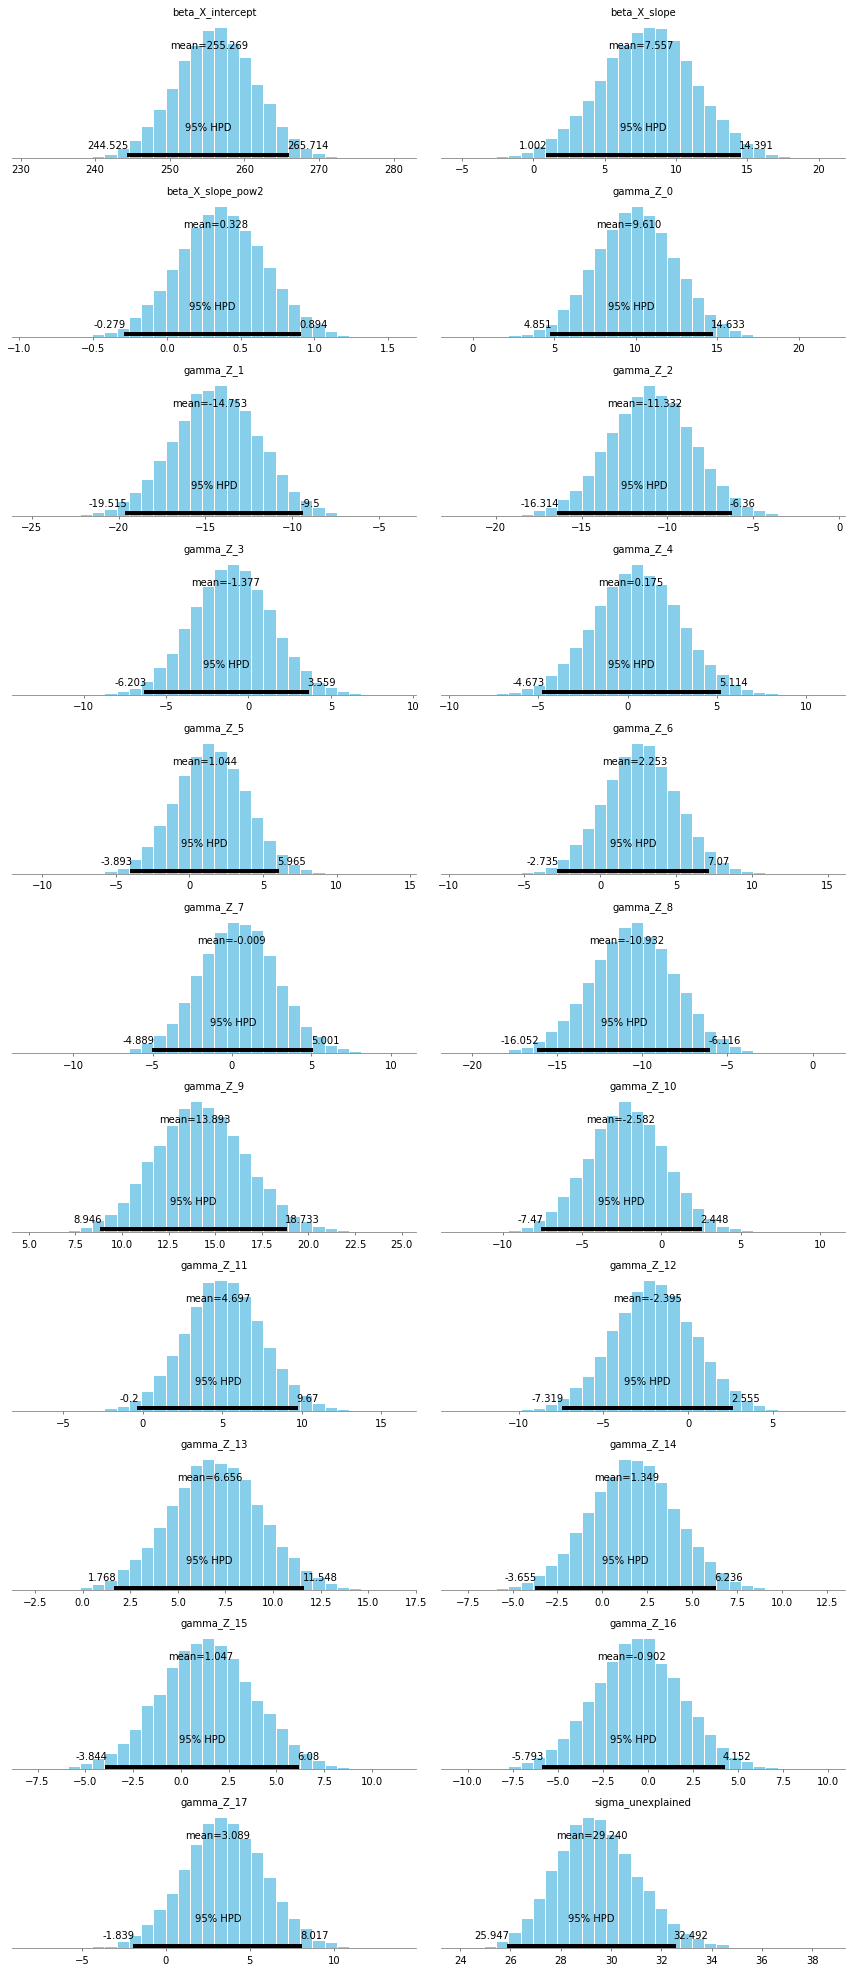

In [49]:
pm.plot_posterior(trace_slope_pow2, varnames=['beta_X_intercept', 'beta_X_slope',  'beta_X_slope_pow2',  'gamma_Z', 'sigma_unexplained']);

## Posterior predictive check

In [50]:
trace_df = pm.trace_to_dataframe(trace_slope_pow2)

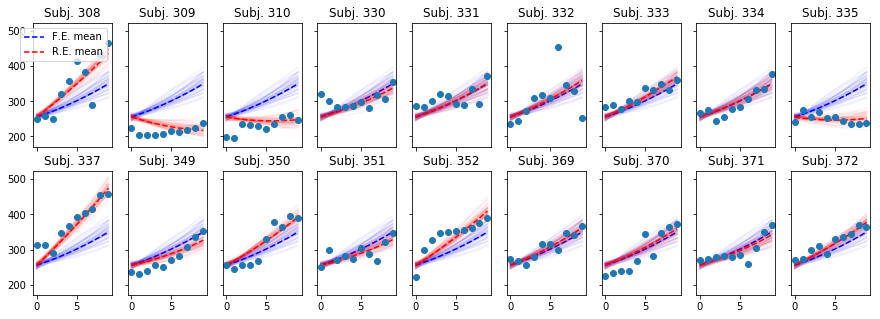

In [51]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1, b2 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500], 
                      trace_df['beta_X_slope_pow2'][::500]):
        ax[i].plot(days, b0 + days*b1 + (days**2)*b2, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, 
               trace_df['beta_X_intercept'].mean() + \
               days*trace_df['beta_X_slope'].mean() + \
               (days**2)*trace_df['beta_X_slope_pow2'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1, b2, g1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500], 
                      trace_df['beta_X_slope_pow2'][::500],
                      trace_df['gamma_Z__{}'.format(i)][::500]):
        ax[i].plot(days, 
                   b0 + days * (b1 + g1) + (days**2) * b2, '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + 
               days * (trace_df['beta_X_slope'].mean() + trace_df['gamma_Z__{}'.format(i)].mean()) + 
               (days**2) * trace_df['beta_X_slope_pow2'].mean(), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend();

100%|███████████████████████████████████████| 250/250 [00:00<00:00, 517.90it/s]


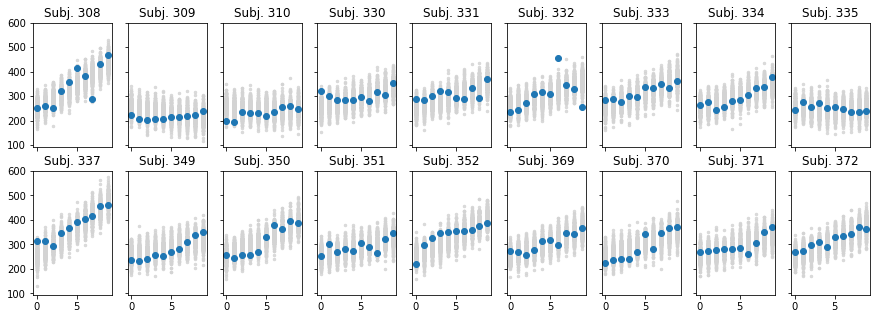

In [52]:
ppc = pm.sample_ppc(trace_slope_pow2, samples=250, model=model_slope_pow2)

days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightgray')
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))

In [53]:
waic = pm.waic(trace_slope_pow2, model_slope_pow2, progressbar=True)
waic.WAIC

20000it [00:02, 8394.07it/s]
d:\dev\pymc3\pymc3\stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


1749.618671508193

In [54]:
loo = pm.loo(trace_slope_pow2, model_slope_pow2)
loo.LOO

d:\dev\pymc3\pymc3\stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


1752.297369637084

## Random effect on the intercepts and slopes
Note: It may be beneficial to center and standardize the data

Design matrix for the fixed effect

In [55]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)

Design matrix for the random effects. Intercept and slope are modelled separately to have more control on the prior

In [56]:
# Random effect on the intercepts and slopes
Z_intercept = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z_intercept = np.asarray(Z_intercept)

Z_slope = patsy.dmatrix('0 + Subject:Days', data=sleep, return_type='dataframe')
Z_slope = np.asarray(Z_slope)

Z = np.concatenate((Z_intercept, Z_slope), axis=1)

print('Z_intercept has shape ({}, {})'.format(*Z_intercept.shape))
print('Z_slope has shape ({}, {})'.format(*Z_slope.shape))
print('Z has shape ({}, {})'.format(*Z.shape))

Z_intercept has shape (180, 18)
Z_slope has shape (180, 18)
Z has shape (180, 36)


In [57]:
Z_intercept

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [58]:
Z_slope

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 8.],
       [0., 0., 0., ..., 0., 0., 9.]])

In [59]:
Z

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 8.],
       [0., 0., 0., ..., 0., 0., 9.]])

In [60]:
Y = np.asarray(sleep['Reaction'])

In [61]:
with pm.Model() as model_intercept_slope:
   
    ## Fixed effect
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # contrain it to positive values
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope)
    
    estimate_X = pm.math.dot(X, beta_X)
    
    ## Random effect
    # Non Centered version
    sigma_Z_intercept = pm.HalfNormal('sigma_Z_intercept', sd=100)
    gamma_Z_intercept_raw = pm.Normal('gamma_Z_intercept_raw', mu=0, sd=1, shape=Z_intercept.shape[1])
    gamma_Z_intercept = pm.Deterministic('gamma_Z_intercept', gamma_Z_intercept_raw * sigma_Z_intercept)

    sigma_Z_slope = pm.HalfNormal('sigma_Z_slope', sd=100)
    gamma_Z_slope_raw = pm.Normal('gamma_Z_slope_raw', mu=0, sd=1, shape=Z_slope.shape[1])
    gamma_Z_slope = pm.Deterministic('gamma_Z_slope', gamma_Z_slope_raw * sigma_Z_slope)
    
    estimate_Z = pm.math.dot(Z_intercept, gamma_Z_intercept) + pm.math.dot(Z_slope, gamma_Z_slope) 
    
    ## likelihood
    mu_estimate = pm.Deterministic('mu_estimate', estimate_X + estimate_Z)
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=1000) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=mu_estimate, sd=sigma_unexplained, observed=Y)
    
    trace_intercept_slope = pm.sample(draws=DRAWS+BURNIN, chains=CHAINS, cores=CORES, tune=TUNE, random_seed=SEED, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_unexplained, gamma_Z_slope_raw, sigma_Z_slope, gamma_Z_intercept_raw, sigma_Z_intercept, beta_X_slope, beta_X_intercept]
Sampling 4 chains: 100%|█████████████| 28000/28000 [04:24<00:00, 106.03draws/s]


In [62]:
trace_intercept_slope = trace_intercept_slope[BURNIN: ]

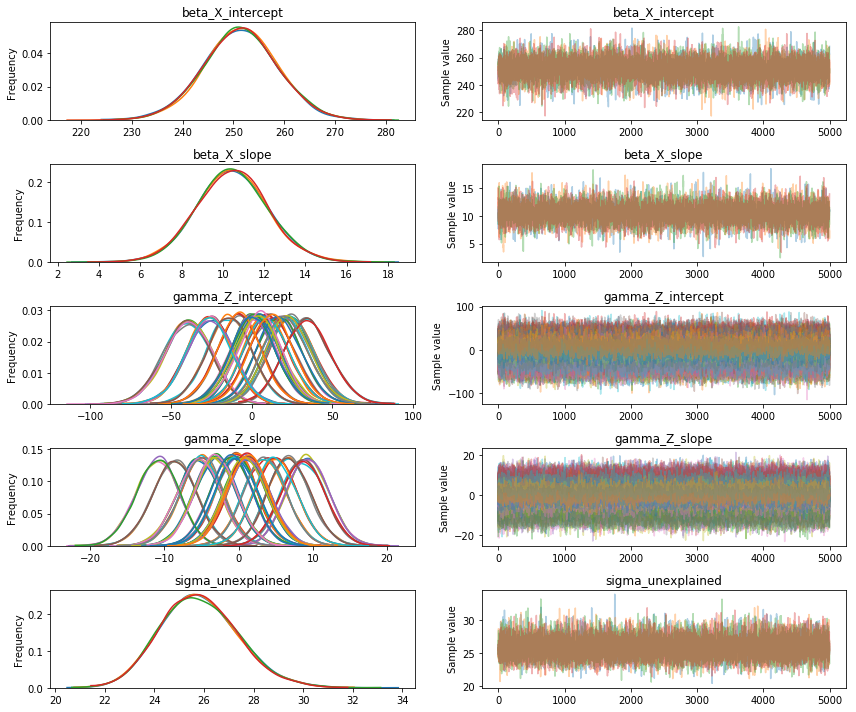

In [63]:
_ = pm.traceplot(trace_intercept_slope, varnames=['beta_X_intercept', 'beta_X_slope', 'gamma_Z_intercept', 'gamma_Z_slope', 'sigma_unexplained'])

In [64]:
pm.summary(trace_intercept_slope)

mean         sd  mc_error     hpd_2.5  \
beta_X_slope                10.470232   1.711616  0.017568    7.032973   
gamma_Z_intercept_raw__0     0.047664   0.532880  0.003596   -1.021441   
gamma_Z_intercept_raw__1    -1.529433   0.564265  0.004532   -2.597662   
gamma_Z_intercept_raw__2    -1.495838   0.558965  0.003985   -2.625089   
gamma_Z_intercept_raw__3     0.945743   0.541434  0.004033   -0.120739   
gamma_Z_intercept_raw__4     0.877309   0.537368  0.003753   -0.149914   
gamma_Z_intercept_raw__5     0.344809   0.529695  0.003311   -0.720955   
gamma_Z_intercept_raw__6     0.651658   0.533088  0.003622   -0.381947   
gamma_Z_intercept_raw__7    -0.290916   0.522642  0.003440   -1.326910   
gamma_Z_intercept_raw__8     0.037414   0.539860  0.003869   -1.028972   
gamma_Z_intercept_raw__9     1.319431   0.554228  0.003985    0.239065   
gamma_Z_intercept_raw__10   -0.986260   0.548455  0.003957   -2.077345   
gamma_Z_intercept_raw__11   -0.535557   0.534065  0.004128   -1.614260   
gamma_Z_intercept_raw__12    0.185562   0.524470  0.003959   -0.872699   
gamma_Z_intercept_raw__13    0.794929   0.534217  0.003719   -0.257901   
gamma_Z_intercept_raw__14    0.122195   0.531780  0.003827   -0.897105   
gamma_Z_intercept_raw__15   -1.017176   0.539038  0.003932   -2.092527   
gamma_Z_intercept_raw__16    0.033375   0.530651  0.003733   -0.997060   
gamma_Z_intercept_raw__17    0.474028   0.530948  0.003904   -0.539296   
gamma_Z_slope_raw__0         1.486028   0.492581  0.003942    0.563707   
gamma_Z_slope_raw__1        -1.372592   0.489960  0.003978   -2.307769   
gamma_Z_slope_raw__2        -0.856048   0.466958  0.004073   -1.796391   
gamma_Z_slope_raw__3        -0.795370   0.459967  0.003742   -1.728282   
gamma_Z_slope_raw__4        -0.511510   0.451245  0.003644   -1.387718   
gamma_Z_slope_raw__5        -0.047874   0.436890  0.003173   -0.926571   
gamma_Z_slope_raw__6        -0.046381   0.444741  0.003233   -0.905447   
gamma_Z_slope_raw__7         0.180019   0.442485  0.003433   -0.699351   
gamma_Z_slope_raw__8        -1.741693   0.507607  0.004258   -2.761007   
gamma_Z_slope_raw__9         1.375372   0.493616  0.003996    0.410145   
gamma_Z_slope_raw__10        0.208154   0.451646  0.003564   -0.690686   
...                               ...        ...       ...         ...   
mu_estimate__151           240.276846  11.108619  0.071101  218.305188   
mu_estimate__152           255.757224   9.551743  0.060710  236.949324   
mu_estimate__153           271.237602   8.421566  0.052814  254.831327   
mu_estimate__154           286.717980   7.903313  0.048642  270.675769   
mu_estimate__155           302.198357   8.115082  0.049152  286.493668   
mu_estimate__156           317.678735   9.005518  0.054212  300.003962   
mu_estimate__157           333.159113  10.401767  0.062730  312.941634   
mu_estimate__158           348.639490  12.130406  0.073515  324.555628   
mu_estimate__159           364.119868  14.069448  0.085714  336.568869   
mu_estimate__160           252.339706  12.631600  0.074369  227.543524   
mu_estimate__161           261.803016  10.861576  0.064678  241.032157   
mu_estimate__162           271.266326   9.372720  0.056714  253.147105   
mu_estimate__163           280.729635   8.317422  0.051287  264.090767   
mu_estimate__164           290.192945   7.872020  0.049245  274.875987   
mu_estimate__165           299.656255   8.137287  0.050996  283.550334   
mu_estimate__166           309.119565   9.050953  0.056185  291.645940   
mu_estimate__167           318.582875  10.444215  0.063982  298.081846   
mu_estimate__168           328.046184  12.153233  0.073562  304.083602   
mu_estimate__169           337.509494  14.063359  0.084320  309.158593   
mu_estimate__170           263.867567  12.565693  0.085109  238.980598   
mu_estimate__171           275.587292  10.808380  0.073119  254.675968   
mu_estimate__172           287.307016   9.334458  0.062966  268.810974   
mu_estimate__173           299.026741

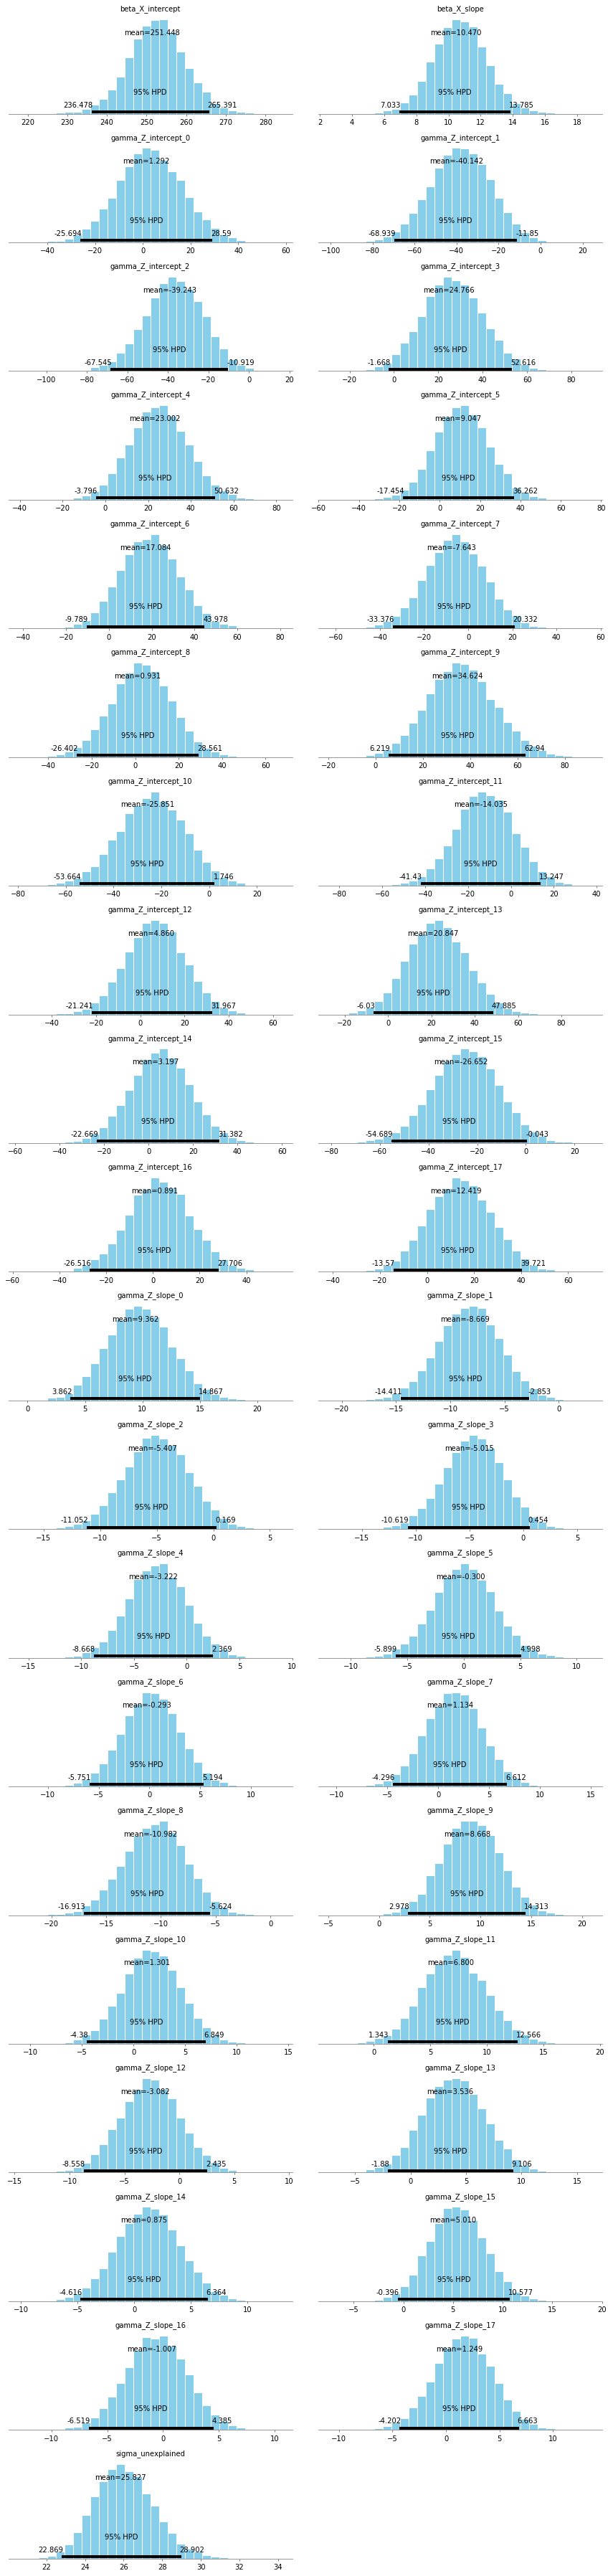

In [65]:
pm.plot_posterior(trace_intercept_slope, varnames=['beta_X_intercept', 'beta_X_slope', 'gamma_Z_intercept', 'gamma_Z_slope', 'sigma_unexplained']);

In [66]:
trace_df = pm.trace_to_dataframe(trace_intercept_slope)
trace_df.head().T

0           1           2           3  \
beta_X_slope                 8.593748   11.160887    7.638389   11.681945   
gamma_Z_intercept_raw__0     0.022832   -0.250105    0.048171    0.121519   
gamma_Z_intercept_raw__1    -0.582931   -1.863258   -1.280413   -2.054446   
gamma_Z_intercept_raw__2    -1.227479   -1.142235   -2.082349   -0.932974   
gamma_Z_intercept_raw__3     1.167212    0.789254    0.551562    1.501230   
gamma_Z_intercept_raw__4     1.719307    1.076275    1.080862    0.880192   
gamma_Z_intercept_raw__5     1.098614   -0.580416    0.958690   -0.598560   
gamma_Z_intercept_raw__6     1.039091    0.688421    0.247993    1.158963   
gamma_Z_intercept_raw__7     0.779679   -1.156903   -0.217286    0.010693   
gamma_Z_intercept_raw__8     0.278201    0.750148   -1.180375    1.653349   
gamma_Z_intercept_raw__9     0.859351    1.378771    0.352636    2.362719   
gamma_Z_intercept_raw__10   -1.139592   -1.331435   -0.740512   -1.127392   
gamma_Z_intercept_raw__11    0.235073   -0.132052   -0.720920   -0.161709   
gamma_Z_intercept_raw__12    0.738341   -0.409540   -0.303759    1.102591   
gamma_Z_intercept_raw__13    0.720552    0.415695    0.612518    0.524126   
gamma_Z_intercept_raw__14    0.349565   -0.289094    0.009316    0.258115   
gamma_Z_intercept_raw__15   -1.646556   -0.787539   -2.070270   -0.226099   
gamma_Z_intercept_raw__16    0.964039   -0.771973    0.160851   -0.164469   
gamma_Z_intercept_raw__17    0.904907   -0.424496    0.711360    0.193592   
gamma_Z_slope_raw__0         1.395460    1.541055    1.829929    1.477509   
gamma_Z_slope_raw__1        -1.140891   -1.457848   -1.080535   -1.091555   
gamma_Z_slope_raw__2         0.018960   -1.185304   -0.227314   -1.213225   
gamma_Z_slope_raw__3        -0.507942   -0.763249   -0.554716   -0.722843   
gamma_Z_slope_raw__4        -0.240182   -0.807660   -0.275816   -0.565368   
gamma_Z_slope_raw__5        -0.151277    0.394817   -0.037945    0.212964   
gamma_Z_slope_raw__6         0.077760   -0.261503    0.327140   -0.501206   
gamma_Z_slope_raw__7        -0.101432    0.737745    0.189285    0.048789   
gamma_Z_slope_raw__8        -1.412100   -2.830637   -0.667359   -3.141328   
gamma_Z_slope_raw__9         1.764237    1.520889    1.586390    1.397461   
gamma_Z_slope_raw__10        0.605202    0.542886    0.316571    0.322976   
...                               ...         ...         ...         ...   
mu_estimate__151           220.476565  246.413361  223.010247  251.366556   
mu_estimate__152           240.237871  260.590038  242.735990  264.268949   
mu_estimate__153           259.999177  274.766715  262.461733  277.171342   
mu_estimate__154           279.760483  288.943392  282.187476  290.073734   
mu_estimate__155           299.521789  303.120069  301.913219  302.976127   
mu_estimate__156           319.283095  317.296746  321.638962  315.878520   
mu_estimate__157           339.044401  331.473423  341.364706  328.780912   
mu_estimate__158           358.805708  345.650101  361.090449  341.683305   
mu_estimate__159           378.567014  359.826778  380.816192  354.585698   
mu_estimate__160           270.740619  232.651865  263.408508  239.755956   
mu_estimate__161           277.124588  244.986049  271.403481  250.963754   
mu_estimate__162           283.508557  257.320232  279.398455  262.171552   
mu_estimate__163           289.892526  269.654416  287.393428  273.379350   
mu_estimate__164           296.276495  281.988599  295.388402  284.587148   
mu_estimate__165           302.660465  294.322783  303.383375  295.794946   
mu_estimate__166           309.044434  306.656966  311.378349  307.002744   
mu_estimate__167           315.428403  318.991150  319.373322  318.210543   
mu_estimate__168           321.812372  331.325333  327.368296  329.418341   
mu_estimate__169           328.196341  343.659517  335.363269  340.626139   
mu_estimate__170           269.154491  241.919911  278.243584  247.261158   
mu_estimate__171           281.6

## Posterior predictive check

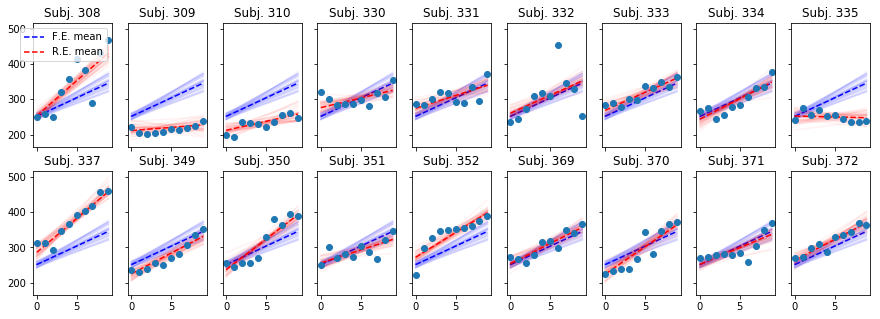

In [67]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500]):
        ax[i].plot(days, b0 + days*b1, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1, g0, g1 in zip(trace_df['beta_X_intercept'][::500], 
                      trace_df['beta_X_slope'][::500],
                      trace_df['gamma_Z_intercept__{}'.format(i)][::500], 
                      trace_df['gamma_Z_slope__{}'.format(i)][::500]):
        ax[i].plot(days, (b0 + g0) + days * (b1 + g1), '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z_intercept__{}'.format(i)].mean() + 
               days * (trace_df['beta_X_slope'].mean() + trace_df['gamma_Z_slope__{}'.format(i)].mean()), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend()

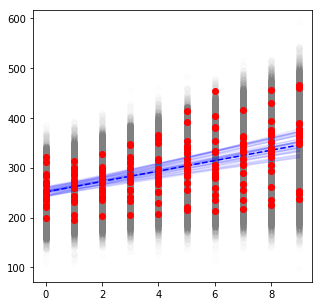

In [68]:
# Posterior distribution
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

n_draws = 25
for idx, reaction, day in zip(sleep.index-1, sleep.Reaction, sleep.Days):
    for mu, sigma in zip(trace_df['mu_estimate__{}'.format(idx)][1000::500], trace_df['sigma_unexplained'][1000::500]):
        ax.plot(np.repeat(day, n_draws), np.random.normal(loc=mu, scale=sigma, size=n_draws),
                'o',color=(0.5, 0.5, 0.5), alpha=0.01)
    
for b0, b1 in zip(trace_df['beta_X_intercept'][1000::500], trace_df['beta_X_slope'][1000::500]):
    ax.plot(np.unique(sleep.Days), b0 + np.unique(sleep.Days)*b1, '-b', alpha=0.1)

ax.plot(days, trace_df['beta_X_intercept'].mean() + days*trace_df['beta_X_slope'].mean(), '--b')

for idx, reaction, day in zip(sleep.index-1, sleep.Reaction, sleep.Days):
    ax.plot(day, reaction, 'ro', alpha=1)


In [69]:
ppc = pm.sample_ppc(trace_intercept_slope, samples=250, model=model_intercept_slope)

100%|███████████████████████████████████████| 250/250 [00:00<00:00, 335.76it/s]


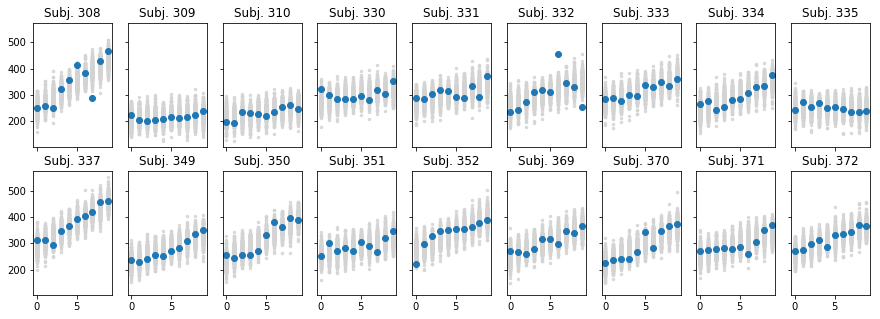

In [70]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightgray')
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))


In [71]:
waic = pm.waic(trace_intercept_slope, model_intercept_slope)
waic.WAIC

d:\dev\pymc3\pymc3\stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


1718.428260106812

In [72]:
loo = pm.loo(trace_intercept_slope, model_intercept_slope)
loo.LOO

d:\dev\pymc3\pymc3\stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


1722.5077944089967

## Include second order terms

In [73]:
X = patsy.dmatrix("1 + Days + np.power(Days, 2)", data=sleep, return_type='dataframe')
X = np.asarray(X)
X

array([[ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.],
       [ 1.,  7., 49.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  0.,  0.],
       [ 1.,  1.

In [74]:
Z_intercept = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z_intercept = np.asarray(Z_intercept)

Z_slope = patsy.dmatrix('0 + Subject:Days', data=sleep, return_type='dataframe')
Z_slope = np.asarray(Z_slope)

Z_slope_pow2 = patsy.dmatrix('0 + Subject:np.power(Days, 2)', data=sleep, return_type='dataframe')
Z_slope_pow2 = np.asarray(Z_slope_pow2)

Z = np.concatenate((Z_intercept, Z_slope, Z_slope_pow2), axis=1)

print('Z_intercept has shape ({}, {})'.format(*Z_intercept.shape))
print('Z_slope has shape ({}, {})'.format(*Z_slope.shape))
print('Z_slope_pow2 has shape ({}, {})'.format(*Z_slope_pow2.shape))

print('Z has shape ({}, {})'.format(*Z.shape))

Z_intercept has shape (180, 18)
Z_slope has shape (180, 18)
Z_slope_pow2 has shape (180, 18)
Z has shape (180, 54)


In [75]:
Y = np.asarray(sleep['Reaction'])

In [76]:
with pm.Model() as model_intercept_slope_pow2:
   
    ## Fixed effect
    beta_X_intercept = pm.HalfNormal('beta_X_intercept', sd=10000) # contrain it to positive values
    beta_X_slope = pm.Normal('beta_X_slope', mu=0, sd=100)
    beta_X_slope_pow2 = pm.Normal('beta_X_slope_pow2', mu=0, sd=100)
    beta_X = tt.stack(beta_X_intercept, beta_X_slope, beta_X_slope_pow2)
    
    estimate_X = pm.math.dot(X, beta_X)
    
    ## Random effect
    # Non Centered version
    sigma_Z_intercept = pm.HalfNormal('sigma_Z_intercept', sd=100)
    gamma_Z_intercept_raw = pm.Normal('gamma_Z_intercept_raw', mu=0, sd=1, shape=Z_intercept.shape[1])
    gamma_Z_intercept = pm.Deterministic('gamma_Z_intercept', gamma_Z_intercept_raw * sigma_Z_intercept)

    sigma_Z_slope = pm.HalfNormal('sigma_Z_slope', sd=100)
    gamma_Z_slope_raw = pm.Normal('gamma_Z_slope_raw', mu=0, sd=1, shape=Z_slope.shape[1])
    gamma_Z_slope = pm.Deterministic('gamma_Z_slope', gamma_Z_slope_raw * sigma_Z_slope)
    
    sigma_Z_slope_pow2 = pm.HalfNormal('sigma_Z_slope_pow2', sd=100)
    gamma_Z_slope_raw_pow2 = pm.Normal('gamma_Z_slope_raw_pow2', mu=0, sd=1, shape=Z_slope_pow2.shape[1])
    gamma_Z_slope_pow2 = pm.Deterministic('gamma_Z_slope_pow2', gamma_Z_slope_raw_pow2 * sigma_Z_slope_pow2)
    
    estimate_Z = pm.math.dot(Z_intercept, gamma_Z_intercept) + \
                 pm.math.dot(Z_slope, gamma_Z_slope) + \
                 pm.math.dot(Z_slope_pow2, gamma_Z_slope_pow2)
        
    ## likelihood
    mu_estimate = pm.Deterministic('mu_estimate', estimate_X + estimate_Z)
    sigma_unexplained = pm.HalfNormal('sigma_unexplained', sd=1000) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=mu_estimate, sd=sigma_unexplained, observed=Y)
    
    trace_intercept_slope_pow2 = pm.sample(draws=DRAWS+BURNIN, chains=CHAINS, cores=CORES, tune=TUNE, random_seed=SEED, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_unexplained, gamma_Z_slope_raw_pow2, sigma_Z_slope_pow2, gamma_Z_slope_raw, sigma_Z_slope, gamma_Z_intercept_raw, sigma_Z_intercept, beta_X_slope_pow2, beta_X_slope, beta_X_intercept]
Sampling 4 chains: 100%|██████████████| 28000/28000 [07:34<00:00, 61.64draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [77]:
trace_intercept_slope_pow2 = trace_intercept_slope_pow2[BURNIN: ]

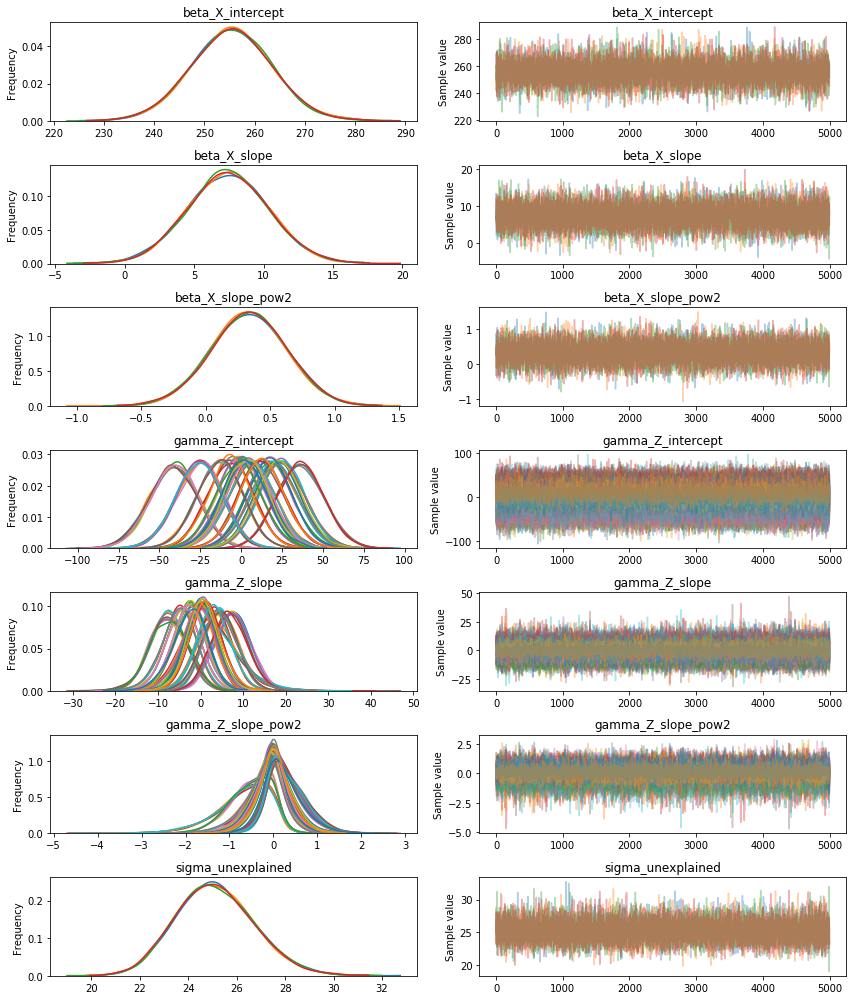

In [78]:
_ = pm.traceplot(trace_intercept_slope_pow2, varnames=['beta_X_intercept', 'beta_X_slope', 'beta_X_slope_pow2', 'gamma_Z_intercept', 'gamma_Z_slope', 'gamma_Z_slope_pow2', 'sigma_unexplained'])

In [79]:
trace_df = pm.trace_to_dataframe(trace_intercept_slope_pow2)

No handles with labels found to put in legend.


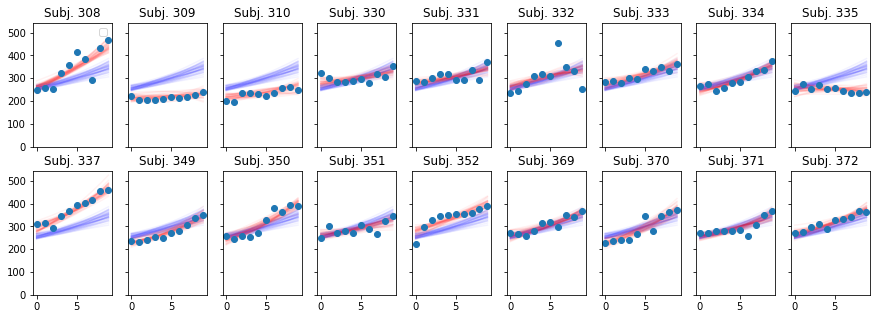

In [80]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1, b2 in zip(trace_df['beta_X_intercept'][::500], 
                          trace_df['beta_X_slope'][::500], 
                          trace_df['beta_X_slope_pow2'][::500]):
        
        ax[i].plot(days, b0 + days*b1 + (days**2)*b2, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

#for i, subject in enumerate(subject_ids):
#    ax[i].plot(days, 
#               trace_df['beta_X_intercept'].mean() + \
#               days*trace_df['beta_X_slope'].mean() + \
#               (days**2)*trace_df['beta_X_slope_pow2'].mean(), '--b', label='F.E. mean')

# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1, b2, g0, g1, g2 in zip(trace_df['beta_X_intercept'][::500], 
                                      trace_df['beta_X_slope'][::500], 
                                      trace_df['beta_X_slope_pow2'][::500],
                                      trace_df['gamma_Z_intercept__{}'.format(i)][::500], 
                                      trace_df['gamma_Z_slope__{}'.format(i)][::500],
                                      trace_df['gamma_Z_slope_pow2__{}'.format(i)][::500]):
        ax[i].plot(days, (b0 + g0) + (b1 + g1)*days + (b2 + g2)*(days**2), '-r', alpha=0.05)
  
#for i, subject in enumerate(subject_ids):
#    ax[i].plot(days,
#               (trace_df['beta_X_intercept'].mean() + trace_df['gamma_Z_intercept__{}'.format(i)].mean()) + 
#               days * (trace_df['beta_X_slope'].mean() + trace_df['gamma_Z_slope__{}'.format(i)].mean()) + 
#               (days**2) * (trace_df['beta_X_slope_pow2'].mean() + trace_df['gamma_Z_slope_pow2__{}'.format(i)].mean()), '--r', 
#               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

for axi in ax:
    axi.set_ylim(0, )
    
ax[0].legend();

In [81]:
ppc = pm.sample_ppc(trace_intercept_slope_pow2, samples=250, model=model_intercept_slope_pow2)

100%|███████████████████████████████████████| 250/250 [00:00<00:00, 346.00it/s]


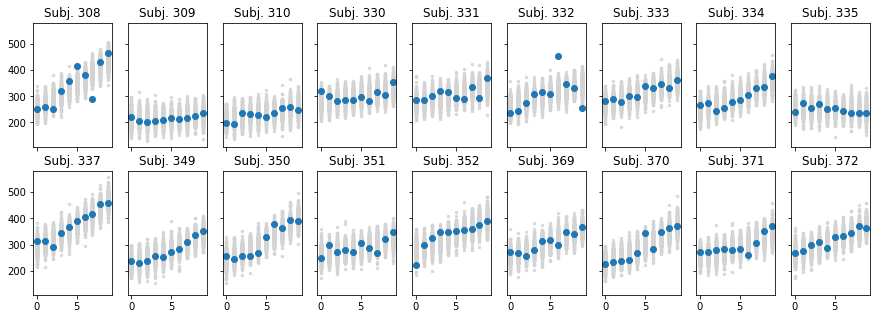

In [82]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()
    
# Main effect  
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, ppc['y_likelihood'].T[sleep.Subject==subject], marker='.', markersize=5, linestyle='none', alpha=0.8, color='lightgray')
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    ax[i].set_title('Subj. {}'.format(subject))


## Compare the first order models

In [83]:
# By setting the name of the model, the interpretation of the dataframe containing the comparison is easier. Otherwise, instead of the name, the index would be the order of insertion
model_intercept.name = 'model_intercept'
model_slope.name = 'model_slope'
model_intercept_slope.name = 'model_intercept_slope'

In [84]:
pm.compare({model_intercept: trace_intercept, 
            model_slope: trace_slope,
            model_intercept_slope: trace_intercept_slope}, ic='WAIC')

d:\dev\pymc3\pymc3\stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
d:\dev\pymc3\pymc3\stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
d:\dev\pymc3\pymc3\stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC  pWAIC  dWAIC weight     SE    dSE var_warn
model_intercept_slope  1718.43  32.74      0    0.9  44.46      0        1
model_slope            1748.73  20.79   30.3      0  35.05  13.56        1
model_intercept        1769.42  19.17  50.99    0.1  28.54  23.23        1

In [85]:
pm.compare({model_intercept: trace_intercept, 
            model_slope: trace_slope,
            model_intercept_slope: trace_intercept_slope}, ic='LOO')

d:\dev\pymc3\pymc3\stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")
d:\dev\pymc3\pymc3\stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model a

LOO   pLOO   dLOO weight     SE    dSE shape_warn
model_intercept_slope  1722.51  34.78      0    0.9  45.69      0          1
model_slope            1750.71  21.79   28.2      0  35.75  13.97          1
model_intercept        1769.98  19.45  47.47    0.1  28.66   24.2          0

## Khatri Rao product to construct Z

In [86]:
J = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
J = np.asarray(J)
J.shape

(180, 18)

In [87]:
X.shape

(180, 3)

In [88]:
Z_kr = np.zeros((J.shape[0], X.shape[1]*J.shape[1]))
Z_kr.shape

(180, 54)

In [89]:
np.kron(J[0, :], X[0, :]).shape

(54,)

In [90]:
for ji in np.arange(0, J.shape[1]):
    for xi in np.arange(0, X.shape[1]):
        Z_kr[ji, :] = np.kron(J[ji, :], X[xi, :])

In [91]:
Z_kr.shape

(180, 54)

In [92]:
Z.shape

(180, 54)

In [93]:
Z_kr[:10, :10]

array([[1., 2., 4., 0., 0., 0., 0., 0., 0., 0.],
       [1., 2., 4., 0., 0., 0., 0., 0., 0., 0.],
       [1., 2., 4., 0., 0., 0., 0., 0., 0., 0.],
       [1., 2., 4., 0., 0., 0., 0., 0., 0., 0.],
       [1., 2., 4., 0., 0., 0., 0., 0., 0., 0.],
       [1., 2., 4., 0., 0., 0., 0., 0., 0., 0.],
       [1., 2., 4., 0., 0., 0., 0., 0., 0., 0.],
       [1., 2., 4., 0., 0., 0., 0., 0., 0., 0.],
       [1., 2., 4., 0., 0., 0., 0., 0., 0., 0.],
       [1., 2., 4., 0., 0., 0., 0., 0., 0., 0.]])

In [94]:
Z[-10:-1, -10:-1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])